In [1]:
# Este comando descarga el repositorio entero a una carpeta llamada 'TFMDS' en Colab.
#!git clone https://github.com/jmorala/TFMDS.git

# Inicializar directorios
Clonar repositorio github
Posicionarse en el directorio raíz

In [2]:
import os
import sys

# Detectar si estamos en Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Configurar el directorio de trabajo según el entorno
if IN_COLAB:
    project_dir = '/content/TFMDS'  # Ruta típica en Colab
    os.chdir(project_dir)
else:
    # En VS Code local
    project_dir = r'C:\Users\jmora\Documents\TFMDS'
    os.chdir(project_dir)

# Agregar el directorio del proyecto al path de Python
# (solo si no está ya en el path)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

# Verificación
print("Directorio de trabajo:", os.getcwd())
print("Python path incluye proyecto:", project_dir in sys.path)

Directorio de trabajo: C:\Users\jmora\Documents\TFMDS
Python path incluye proyecto: True


In [3]:
import pandas as pd
import numpy as np
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')

# Importar funciones personalizadas
from lib.metricas import calcular_metricas, comparar_metricas, resumen_metricas, agregar_estadisticas_error
from lib.graficos import (grafico_real_vs_prediccion, grafico_scatter_prediccion, grafico_comparacion_metricas,
                          grafico_distribucion_error, grafico_feature_importance, dashboard_prediccion)

## Lectura de fichero y adaptación de los tipos


In [4]:
df_train = pd.read_csv('datos/df_train.csv', sep=';', parse_dates=['idSecuencia'])
df_test = pd.read_csv('datos/df_test.csv', sep=';', parse_dates=['idSecuencia'])

print("\nInformación de las columnas y tipos de datos:")
print(df_train.info())
print(df_test.info())


Información de las columnas y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625800 entries, 0 to 625799
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idSecuencia         625800 non-null  datetime64[ns]
 1   producto            625800 non-null  int64         
 2   udsVenta            625800 non-null  int64         
 3   bolPromocion        625800 non-null  int64         
 4   bolOpen             625800 non-null  int64         
 5   bolHoliday          625800 non-null  int64         
 6   udsStock            625800 non-null  int64         
 7   rotura_stock        625800 non-null  bool          
 8   dia_semana          625800 non-null  int64         
 9   mes                 625800 non-null  int64         
 10  trimestre           625800 non-null  int64         
 11  lag_ventas_1        625800 non-null  float64       
 12  lag_ventas_2        625800 non-null  fl

# Random Forests (RF)

- Determinar características utilizar FEATURES
- Descomponer serie en Train y Test
- Características a Normalizar/Estandarizar o codificar
- Crear modelos estimando hiperparámetros
- Valorar modelos




In [5]:
# Eliminar días que la tienda está cerrada bolOpne == 0 ya que en modelos tipo Random Forest no aportan nada
df_train = df_train[df_train['bolOpen'] == 1].copy()
df_test = df_test[df_test['bolOpen'] == 1].copy()

# Preparación de datos

In [6]:
# ============================================================================
# CONFIGURACIÓN INICIAL
# ============================================================================

FEATURES = [
    'producto_encoded', 'bolPromocion', 'bolHoliday', 'Cluster',
    'dia_semana', 'mes', 'trimestre',
    'lag_ventas_1', 'lag_ventas_2', 'lag_ventas_3', 'lag_ventas_4',
    'lag_ventas_5', 'lag_ventas_6', 'lag_ventas_7',
    'media_mes_anterior', 'EWMA_corto', 'EWMA_largo', 'Tendencia_EWMA'
]

TARGET = 'udsVenta'

# ============================================================================
# 📊 LISTA PARA ALMACENAR TODAS LAS MÉTRICAS
# ============================================================================
todas_metricas = []  # ← Lista global para todas las métricas

print("="*100)
print("🚀 INICIANDO ANÁLISIS COMPLETO DE RANDOM FOREST")
print("="*100)


🚀 INICIANDO ANÁLISIS COMPLETO DE RANDOM FOREST


# Random Forest global

In [ ]:


# ============================================================================
# 1. MODELO GLOBAL CON OPTUNA
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 1: RANDOM FOREST GLOBAL")
print("="*100)

# Preparar datos
X_train = df_train[FEATURES]
y_train = df_train[TARGET]
X_test = df_test[FEATURES]
y_test = df_test[TARGET]

print(f"\n✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")

# Último 20% como validación temporal
VAL_SIZE = int(len(X_train) * 0.2)

X_tr = X_train.iloc[:-VAL_SIZE]
y_tr = y_train.iloc[:-VAL_SIZE]

X_val = X_train.iloc[-VAL_SIZE:]
y_val = y_train.iloc[-VAL_SIZE:]

print(f"\n✅ X_tr shape: {X_tr.shape}")
print(f"✅ X_val shape: {X_val.shape}")
print(f"✅ y_tr shape: {y_tr.shape}")
print(f"✅ y_val shape: {y_val.shape}")


print("\n🔍 Búsqueda de hiperparámetros con Optuna...")

# =====================================================
#  FUNCION OBJETIVO OPTUNA PARA RANDOM FOREST
# =====================================================

def objective_rf(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 4, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)

    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    mse = mean_squared_error(y_val, preds)
    return mse

tscv = TimeSeriesSplit(n_splits=2)

# =====================================================
# EJECUTAR OPTUNA
# =====================================================
print("\n🔍 Iniciando optimización de hiperparámetros con Optuna para Random Forest...")
start_time = time.perf_counter()

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=40, n_jobs=-1)

elapsed = time.perf_counter() - start_time
print(f"✅ Optuna completado en {elapsed:.2f} segundos")

print("\n🌲 Mejores hiperparámetros RANDOM FOREST:")
print(study_rf.best_params)

best_rf = RandomForestRegressor(
    **study_rf.best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

# Predicciones
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calcular métricas y GUARDAR
metricas_train_global = calcular_metricas(y_train, y_train_pred, 'RF Global Train')
metricas_test_global = calcular_metricas(y_test, y_test_pred, 'RF Global Test')

# todas_metricas.append(metricas_train_global)
todas_metricas.append(metricas_test_global)

print("\n📊 Métricas del Modelo Global:")
resumen_metricas([metricas_train_global, metricas_test_global])


[I 2025-11-21 17:52:06,428] A new study created in memory with name: no-name-83d64175-6d36-4125-97d7-328c0e773828



📍 MODELO 1: RANDOM FOREST GLOBAL

✅ X_train shape: (521202, 18)
✅ X_test shape: (23244, 18)

✅ X_tr shape: (416962, 18)
✅ X_val shape: (104240, 18)
✅ y_tr shape: (416962,)
✅ y_val shape: (104240,)

🔍 Búsqueda de hiperparámetros con Optuna...

🔍 Iniciando optimización de hiperparámetros con Optuna para Random Forest...


[I 2025-11-21 17:57:19,263] Trial 6 finished with value: 3.9137864383763583 and parameters: {'n_estimators': 294, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 6 with value: 3.9137864383763583.
[I 2025-11-21 18:01:23,440] Trial 7 finished with value: 3.8652965604964598 and parameters: {'n_estimators': 240, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 7 with value: 3.8652965604964598.
[I 2025-11-21 18:02:50,572] Trial 3 finished with value: 3.868022778318667 and parameters: {'n_estimators': 274, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 7 with value: 3.8652965604964598.
[I 2025-11-21 18:03:48,249] Trial 4 finished with value: 3.866390748055837 and parameters: {'n_estimators': 324, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_feat

✅ Optuna completado en 5605.53 segundos

🌲 Mejores hiperparámetros RANDOM FOREST:
{'n_estimators': 589, 'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}

📊 Métricas del Modelo Global:

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE    MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
     RF Global Train 1.5487 5.2718 2.2960 0.3529     45.38     138.09 0.6654    89.58
      RF Global Test 1.5822 5.6468 2.3763 0.2631     48.88     143.94 0.7282    96.90

🏆 Mejor modelo: RF Global Train (RMSE: 2.2960)


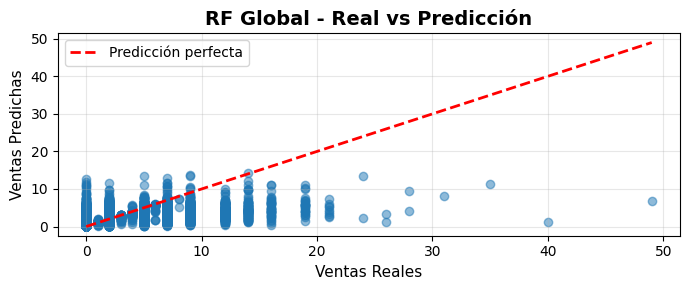

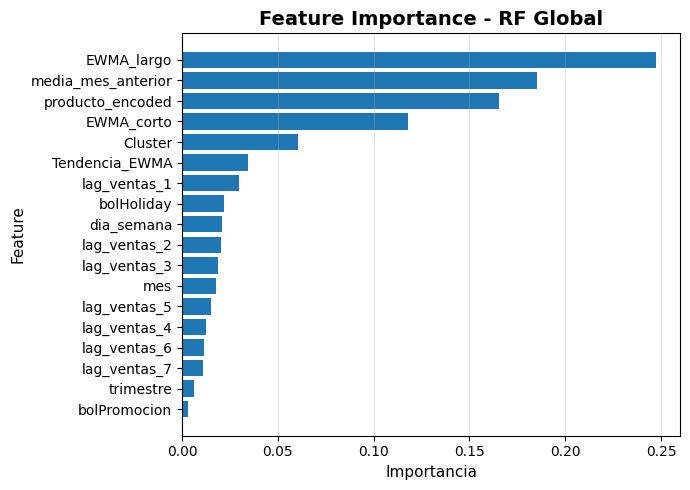

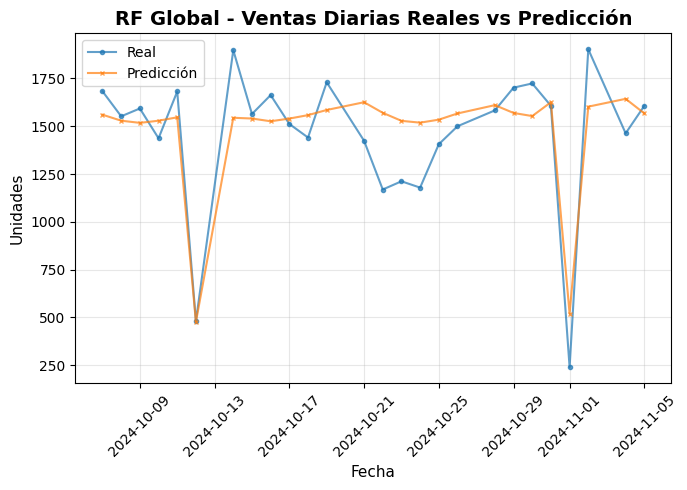

In [9]:

# Visualizaciones del modelo global
df_test_viz = df_test.copy()
df_test_viz['prediccion'] = y_test_pred
df_test_viz['error'] = y_test_pred - df_test_viz[TARGET]

grafico_scatter_prediccion(
    df=df_test_viz,
    col_real=TARGET,
    col_pred='prediccion',
    titulo='RF Global - Real vs Predicción',
    figsize=(7, 3)
)

grafico_feature_importance(
    modelo=best_rf,
    feature_names=FEATURES,
    top_n=len(FEATURES),
    titulo='Feature Importance - RF Global',
    figsize=(7, 5)
)

# Crear dataframe que contenga la suma por día de las predicciones y valores reales
df_daily = df_test_viz.copy()
df_daily['fecha'] = df_daily['idSecuencia'].dt.date
df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
grafico_real_vs_prediccion(
    df=df_daily_sum,
    col_real=TARGET,
    col_pred='prediccion',
    col_fecha='fecha',
    titulo='RF Global - Ventas Diarias Reales vs Predicción',
    figsize=(7, 5)
)


# Random Forest por Cluster


📍 MODELO 2: RANDOM FOREST POR CLUSTER

🔄 Entrenando modelo para Cluster 0...
   ✓ MAE: 1.81 | RMSE: 2.56 | R²: 0.1110


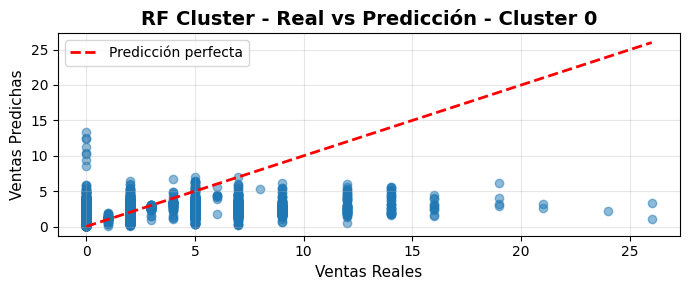

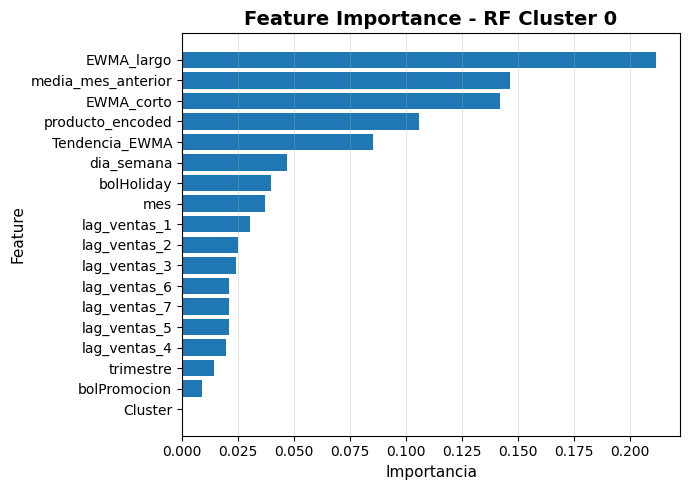

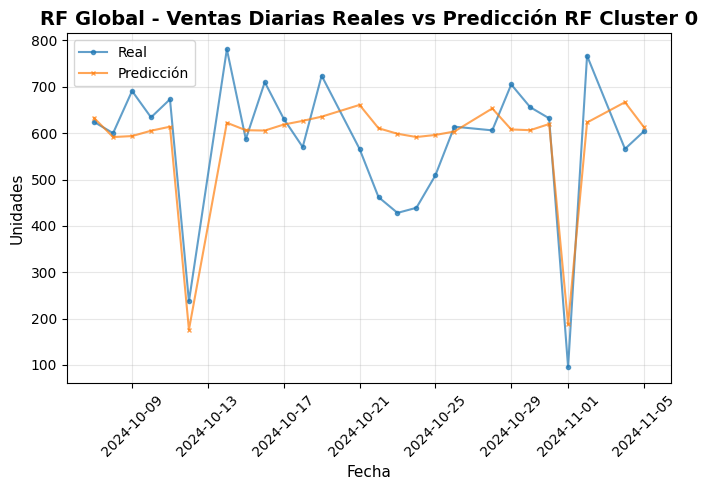


   📍 Producto representativo: 17 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.01
      Error abs medio:          1.81
      Error máximo:            25.00


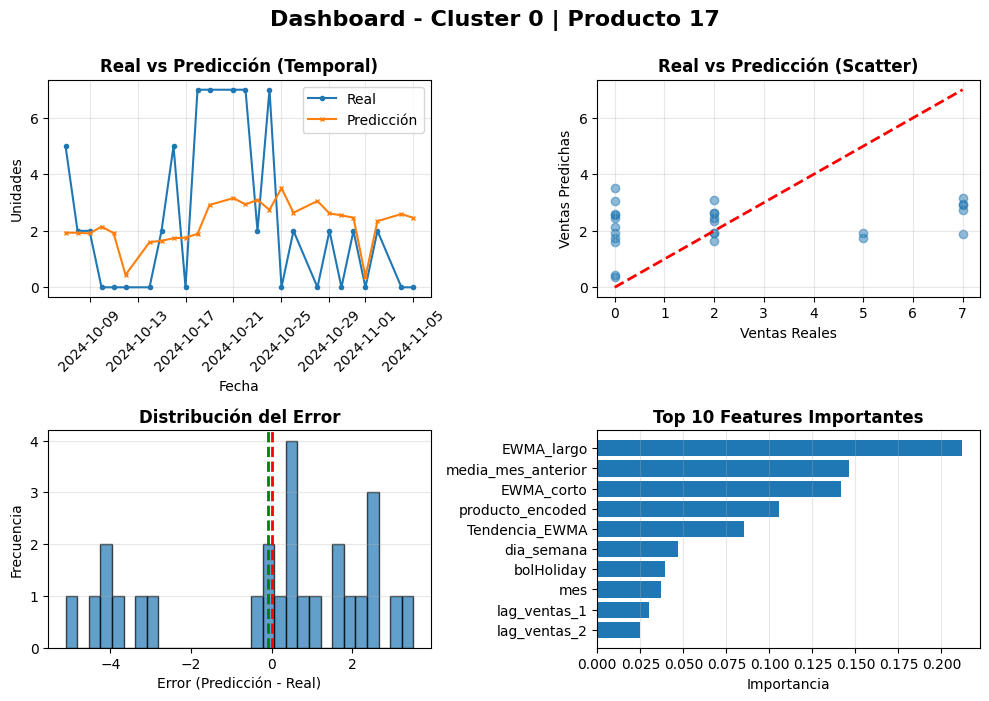


🔄 Entrenando modelo para Cluster 1...
   ✓ MAE: 2.80 | RMSE: 3.60 | R²: 0.1380


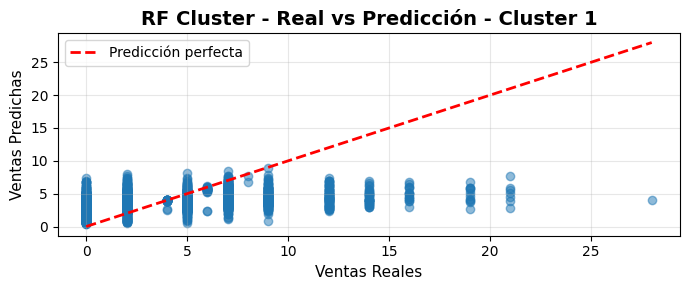

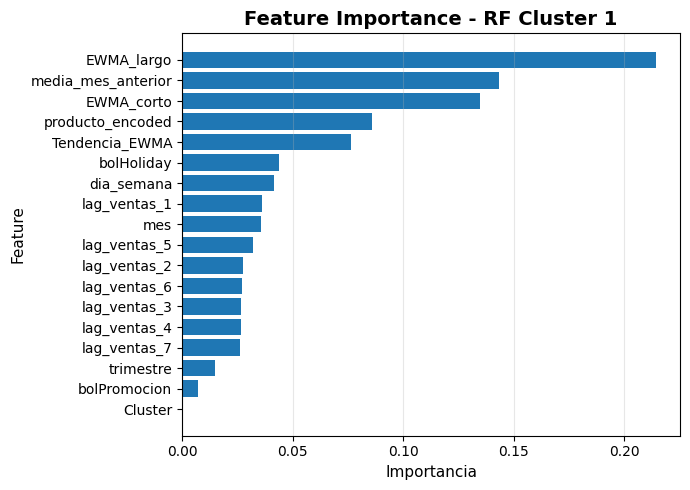

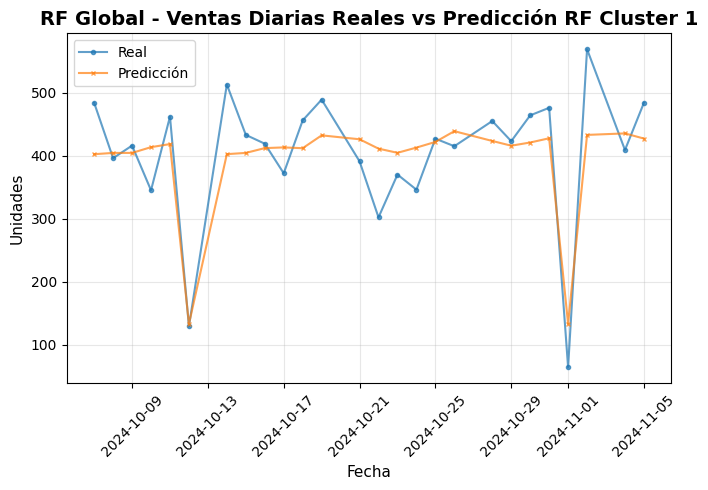


   📍 Producto representativo: 4 (26 registros)
   📊 Estadísticas del error:
      Error medio:             -0.08
      Error abs medio:          2.80
      Error máximo:            23.99


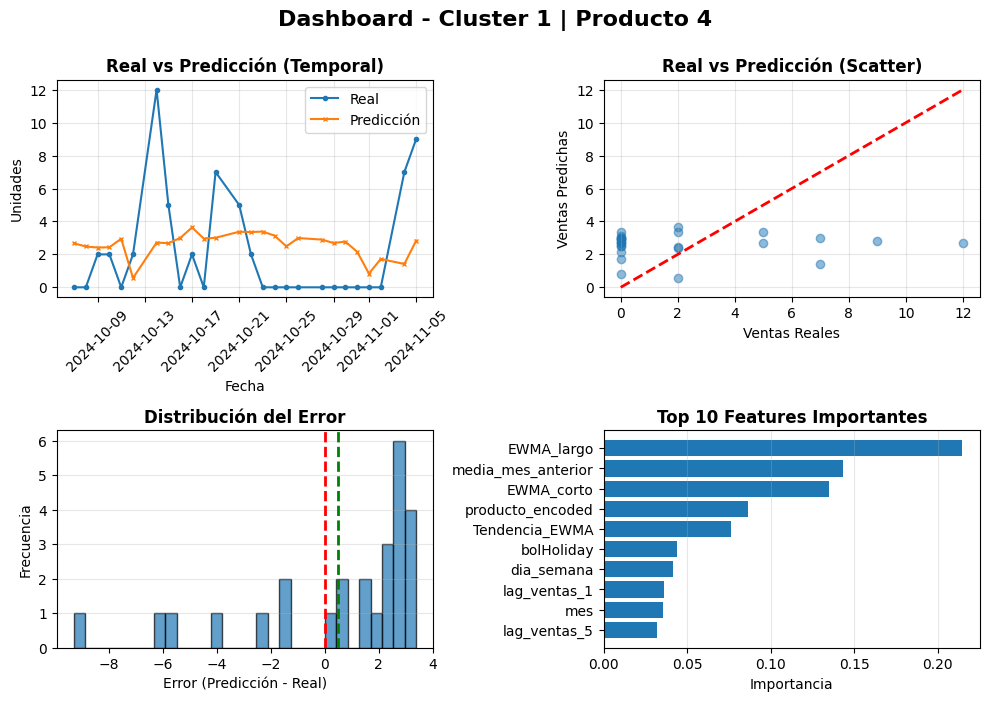


🔄 Entrenando modelo para Cluster 2...
   ✓ MAE: 3.75 | RMSE: 5.16 | R²: 0.1788


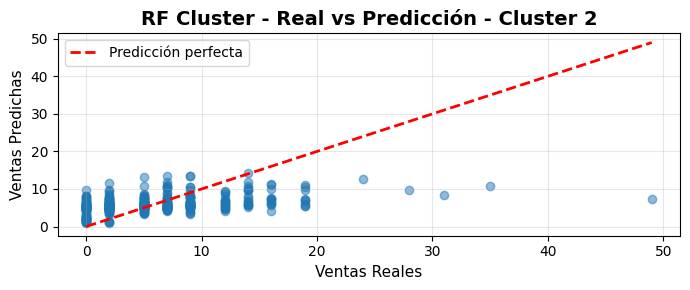

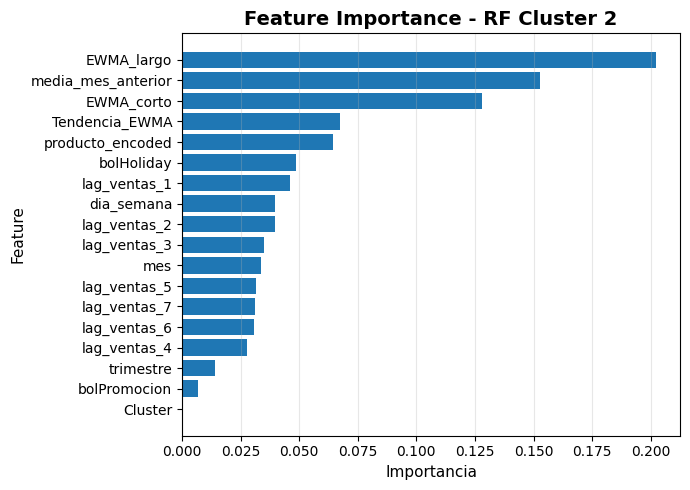

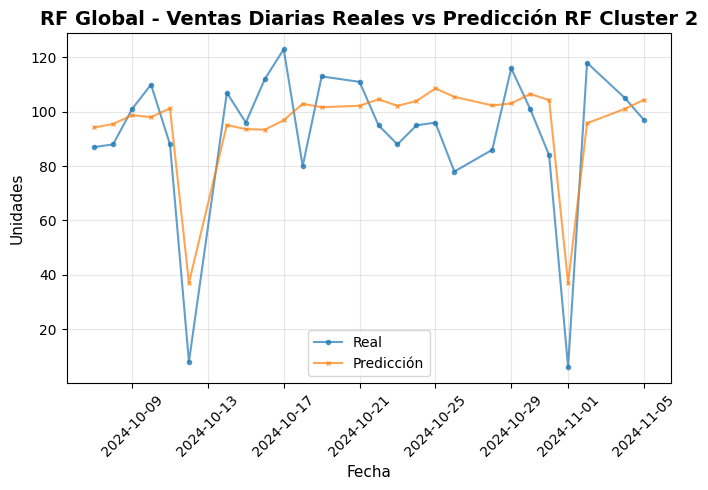


   📍 Producto representativo: 1 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.24
      Error abs medio:          3.75
      Error máximo:            41.75


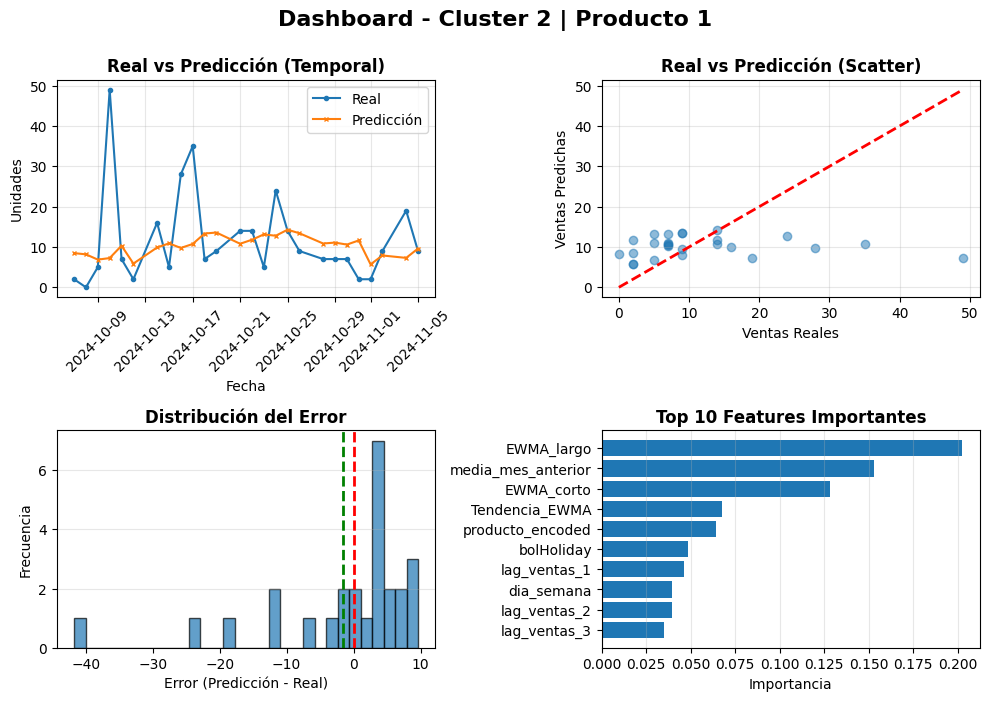


🔄 Entrenando modelo para Cluster 3...
   ✓ MAE: 1.09 | RMSE: 1.66 | R²: 0.0747


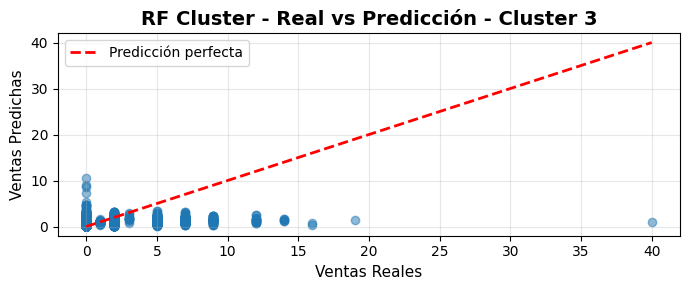

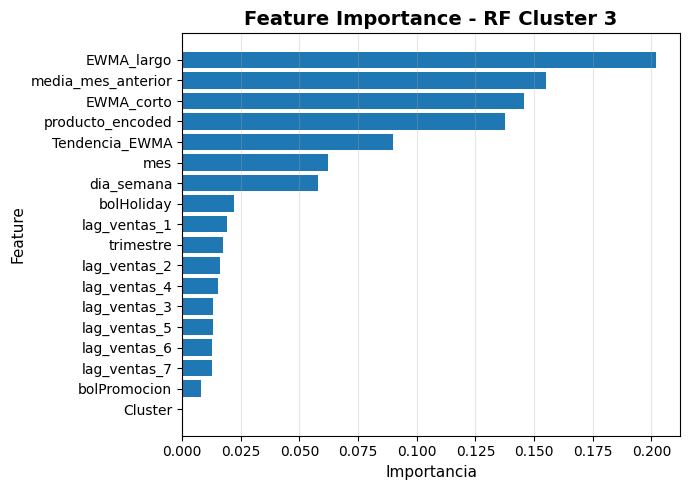

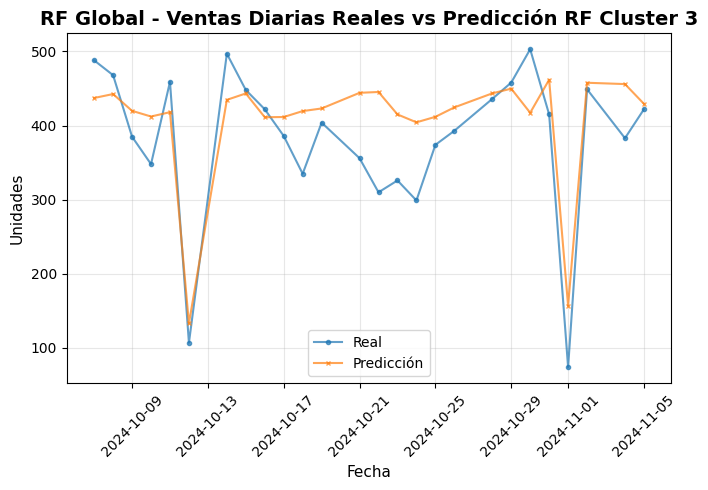


   📍 Producto representativo: 38 (26 registros)
   📊 Estadísticas del error:
      Error medio:              0.06
      Error abs medio:          1.09
      Error máximo:            38.95


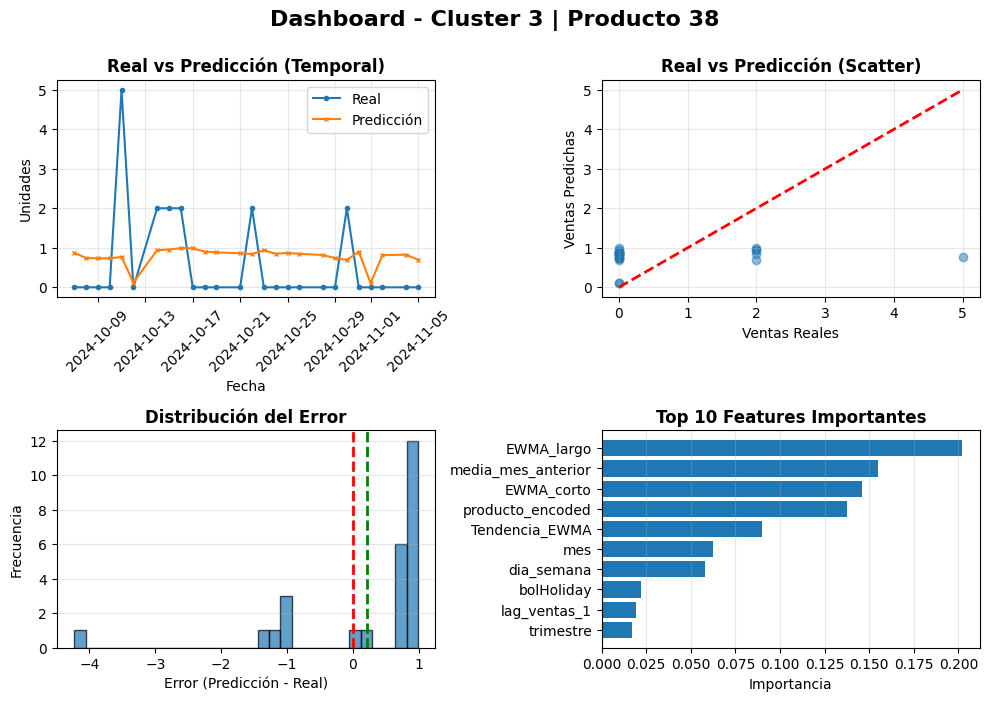

In [10]:


# ============================================================================
# 2. MODELOS POR CLUSTER
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 2: RANDOM FOREST POR CLUSTER")
print("="*100)

modelos_cluster = {}

for cluster in sorted(df_train['Cluster'].unique()):
    print(f"\n🔄 Entrenando modelo para Cluster {cluster}...")
    
    # Filtrar datos
    train_cluster = df_train[df_train['Cluster'] == cluster]
    test_cluster = df_test[df_test['Cluster'] == cluster].dropna()
    
    if len(test_cluster) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    X_train_c = train_cluster[FEATURES]
    y_train_c = train_cluster[TARGET]
    X_test_c = test_cluster[FEATURES]
    y_test_c = test_cluster[TARGET]
    
    # Entrenar
    rf_cluster = RandomForestRegressor(
        **study_rf.best_params,
        random_state=42,
        n_jobs=-1
)
    
    rf_cluster.fit(X_train_c, y_train_c)
    y_pred_c = rf_cluster.predict(X_test_c)
    
    # modelos_cluster[cluster] = rf_cluster
    
    # Calcular métricas y GUARDAR
    metricas_cluster = calcular_metricas(y_test_c, y_pred_c, f"RF Cluster {cluster}")
    todas_metricas.append(metricas_cluster)
    
    print(f"   ✓ MAE: {metricas_cluster['MAE']:.2f} | RMSE: {metricas_cluster['RMSE']:.2f} | R²: {metricas_cluster['R2']:.4f}")
    
    # Visualizaciones del modelo cluster
    df_test_viz = test_cluster.copy()
    df_test_viz['prediccion'] = y_pred_c
    df_test_viz['error'] = y_pred_c - df_test_viz[TARGET]

    grafico_scatter_prediccion(
        df=df_test_viz,
        col_real=TARGET,
        col_pred='prediccion',
        titulo=f'RF Cluster - Real vs Predicción - Cluster {cluster}',
        figsize=(7, 3)
    )

    grafico_feature_importance(
        modelo=rf_cluster,
        feature_names=FEATURES,
        top_n=len(FEATURES),
        titulo=f'Feature Importance - RF Cluster {cluster}',
        figsize=(7, 5)
    )

    # Crear dataframe que contenga la suma por día de las predicciones y valores reales
    df_daily = df_test_viz.copy()
    df_daily['fecha'] = df_daily['idSecuencia'].dt.date
    df_daily_sum = df_daily.groupby('fecha')[[TARGET, 'prediccion']].sum().reset_index()
    grafico_real_vs_prediccion(
        df=df_daily_sum,
        col_real=TARGET,
        col_pred='prediccion',
        col_fecha='fecha',
        titulo=f'RF Global - Ventas Diarias Reales vs Predicción RF Cluster {cluster}',
        figsize=(7, 5)
    )
    
    # Preparar datos para visualización de producto representativo
    test_cluster_pred = test_cluster.copy()
    test_cluster_pred['prediccion'] = y_pred_c
    test_cluster_pred['error'] = y_pred_c - test_cluster_pred[TARGET]
    test_cluster_pred['error_abs'] = np.abs(test_cluster_pred['error'])
    
    # Seleccionar producto representativo
    producto_rep = test_cluster['producto'].value_counts().index[0]
    df_producto = test_cluster_pred[test_cluster_pred['producto'] == producto_rep].copy()
    df_producto = df_producto.sort_values('idSecuencia')
    
    print(f"\n   📍 Producto representativo: {producto_rep} ({len(df_producto)} registros)")
    
    # Estadísticas
    print(f"   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_cluster_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_cluster_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_cluster_pred['error_abs'].max():>8.2f}")
    
    
    dashboard_prediccion(
        df=df_producto,
        col_fecha='idSecuencia',
        col_real=TARGET,
        col_pred='prediccion',
        modelo=rf_cluster,
        feature_names=FEATURES,
        titulo_principal=f'Dashboard - Cluster {cluster} | Producto {producto_rep}',
        figsize=(10, 7)
        )
        


# Random Forest por top 10 productos de ventas


📍 MODELO 3: RANDOM FOREST POR PRODUCTO (TOP 10)

🏆 Top 10 productos: [1, 2, 9, 78, 7, 13, 15, 391, 3, 131]

🔄 Entrenando modelo para Producto 1...
   ✓ MAE: 8.18 | RMSE: 11.52 | R²: -0.0697

   📍 Producto 1
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         2   11.016845 9.016845   9.016845
    2024-10-08         0    9.030741 9.030741   9.030741
    2024-10-09         5    9.106797 4.106797   4.106797

   📊 Estadísticas del error:
      Error medio:             -1.10
      Error abs medio:          8.18
      Error máximo:            39.87
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE    RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 1 8.1817 132.7278 11.5208 -0.0697    117.39      72.54 0.7253    69.29

🏆 Mejor modelo: RF Producto 1 (RMSE: 11.5208)


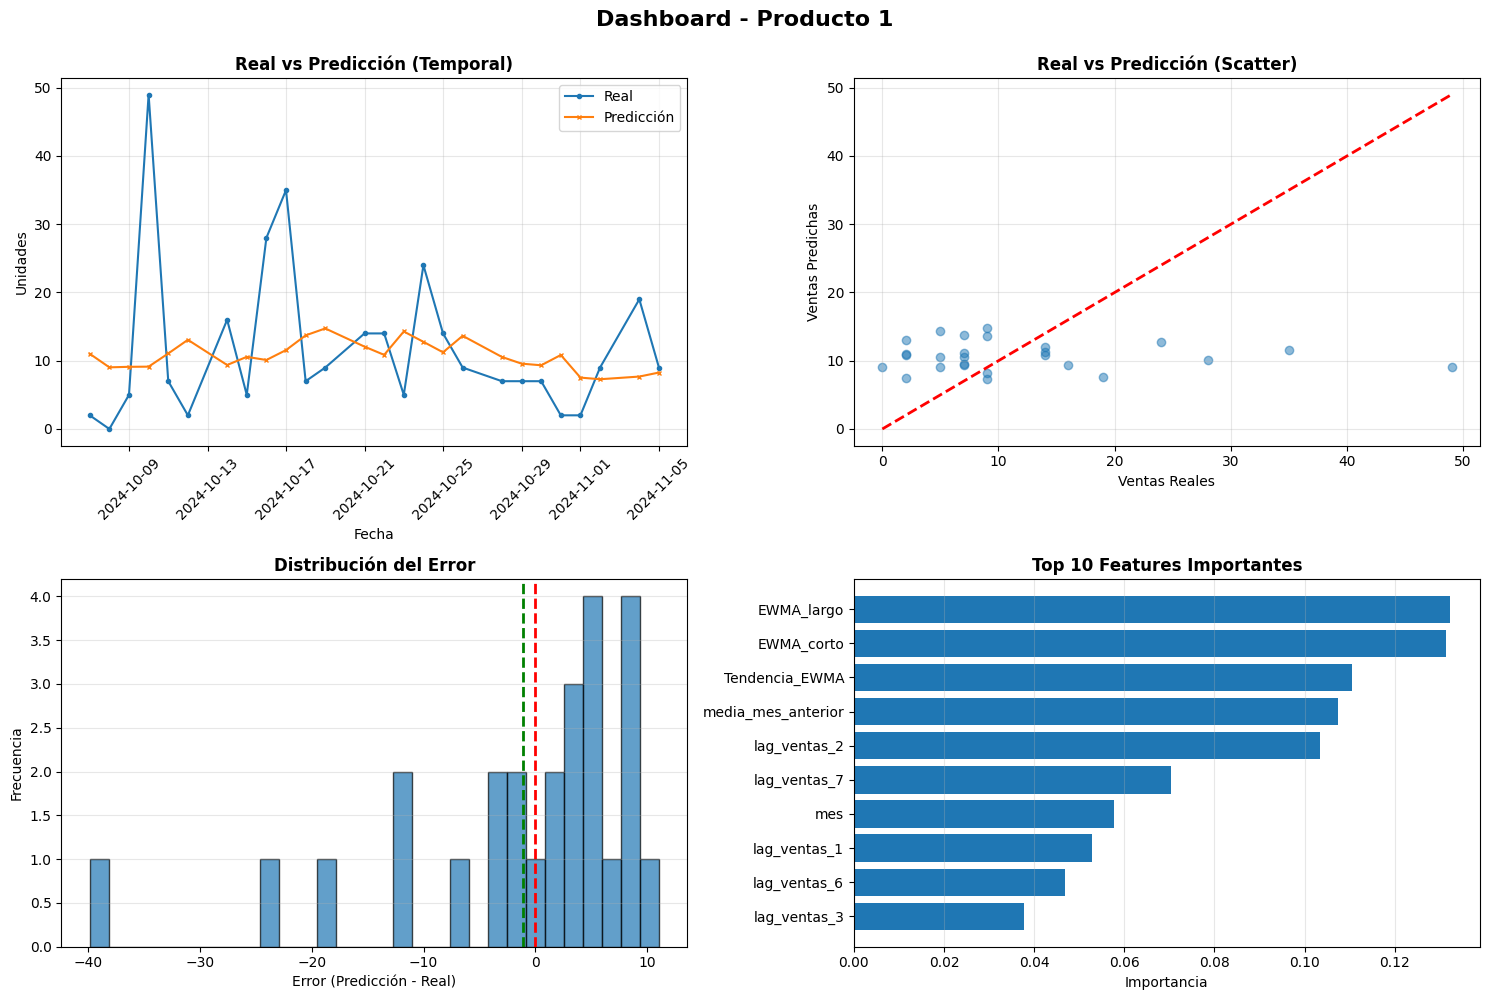


🔄 Entrenando modelo para Producto 2...
   ✓ MAE: 3.90 | RMSE: 4.79 | R²: -0.1210

   📍 Producto 2
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    6.746722 -0.253278   0.253278
    2024-10-08         7    6.770323 -0.229677   0.229677
    2024-10-09        16    7.126802 -8.873198   8.873198

   📊 Estadísticas del error:
      Error medio:              0.92
      Error abs medio:          3.90
      Error máximo:            10.19
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 2 3.9017 22.9172 4.7872 -0.121     82.47      68.73 0.6651    61.86

🏆 Mejor modelo: RF Producto 2 (RMSE: 4.7872)


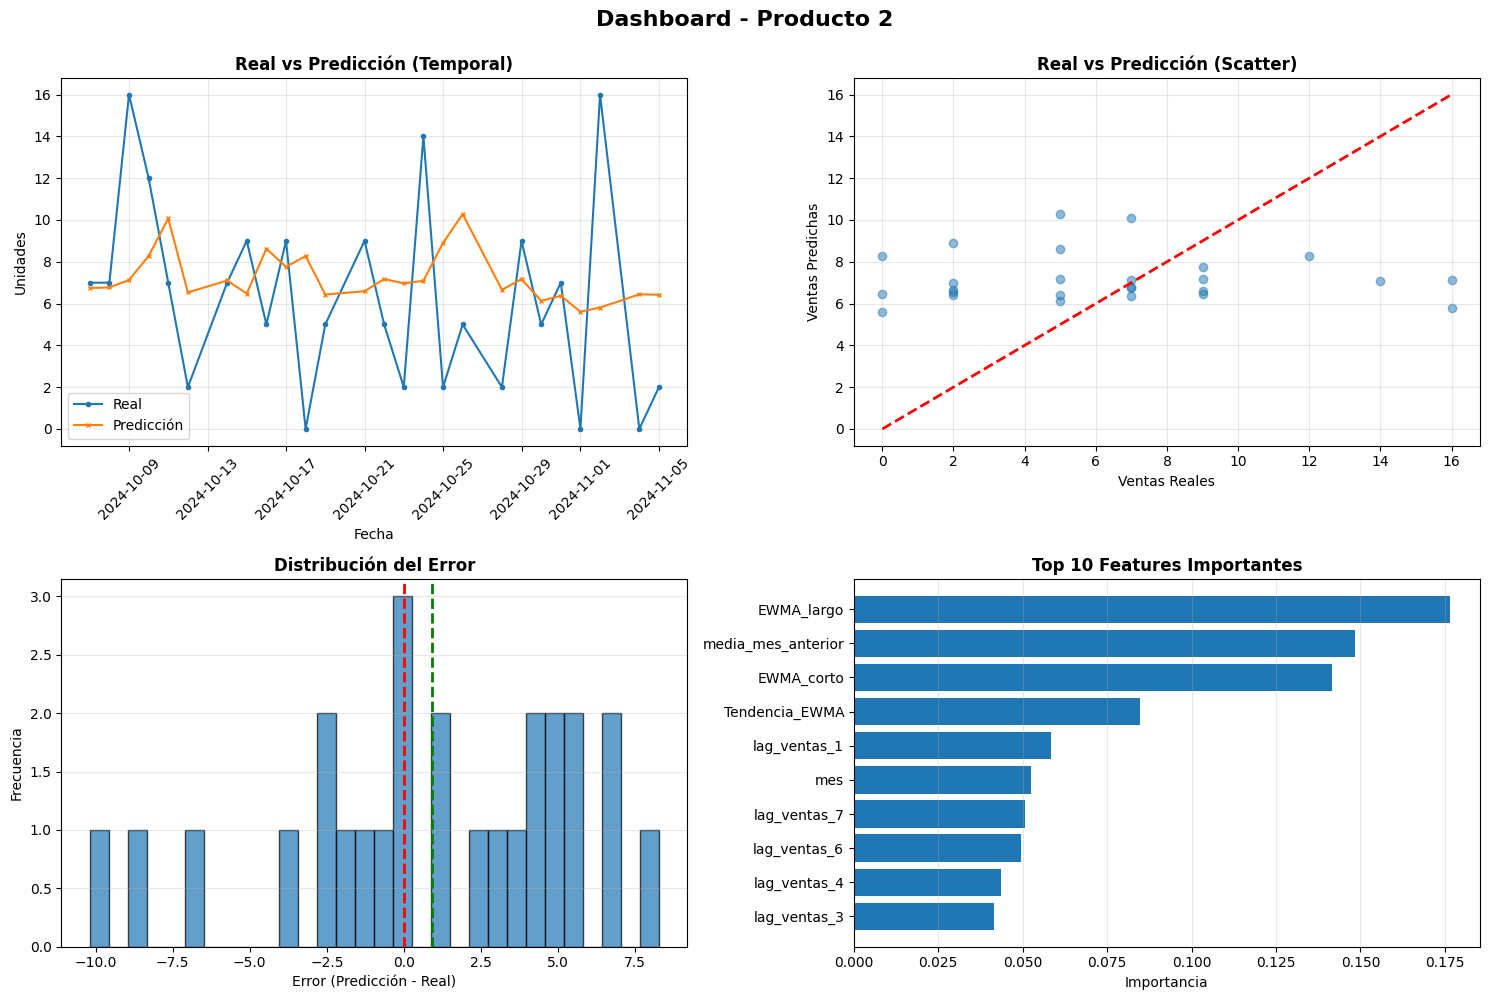


🔄 Entrenando modelo para Producto 9...
   ✓ MAE: 5.26 | RMSE: 5.85 | R²: -0.1122

   📍 Producto 9
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    8.348270 -0.651730   0.651730
    2024-10-08         2    9.579261  7.579261   7.579261
    2024-10-09         5    8.952550  3.952550   3.952550

   📊 Estadísticas del error:
      Error medio:              1.76
      Error abs medio:          5.26
      Error máximo:             9.68
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 9 5.2637 34.2364 5.8512 -0.1122    127.23      87.86 0.7816    81.95

🏆 Mejor modelo: RF Producto 9 (RMSE: 5.8512)


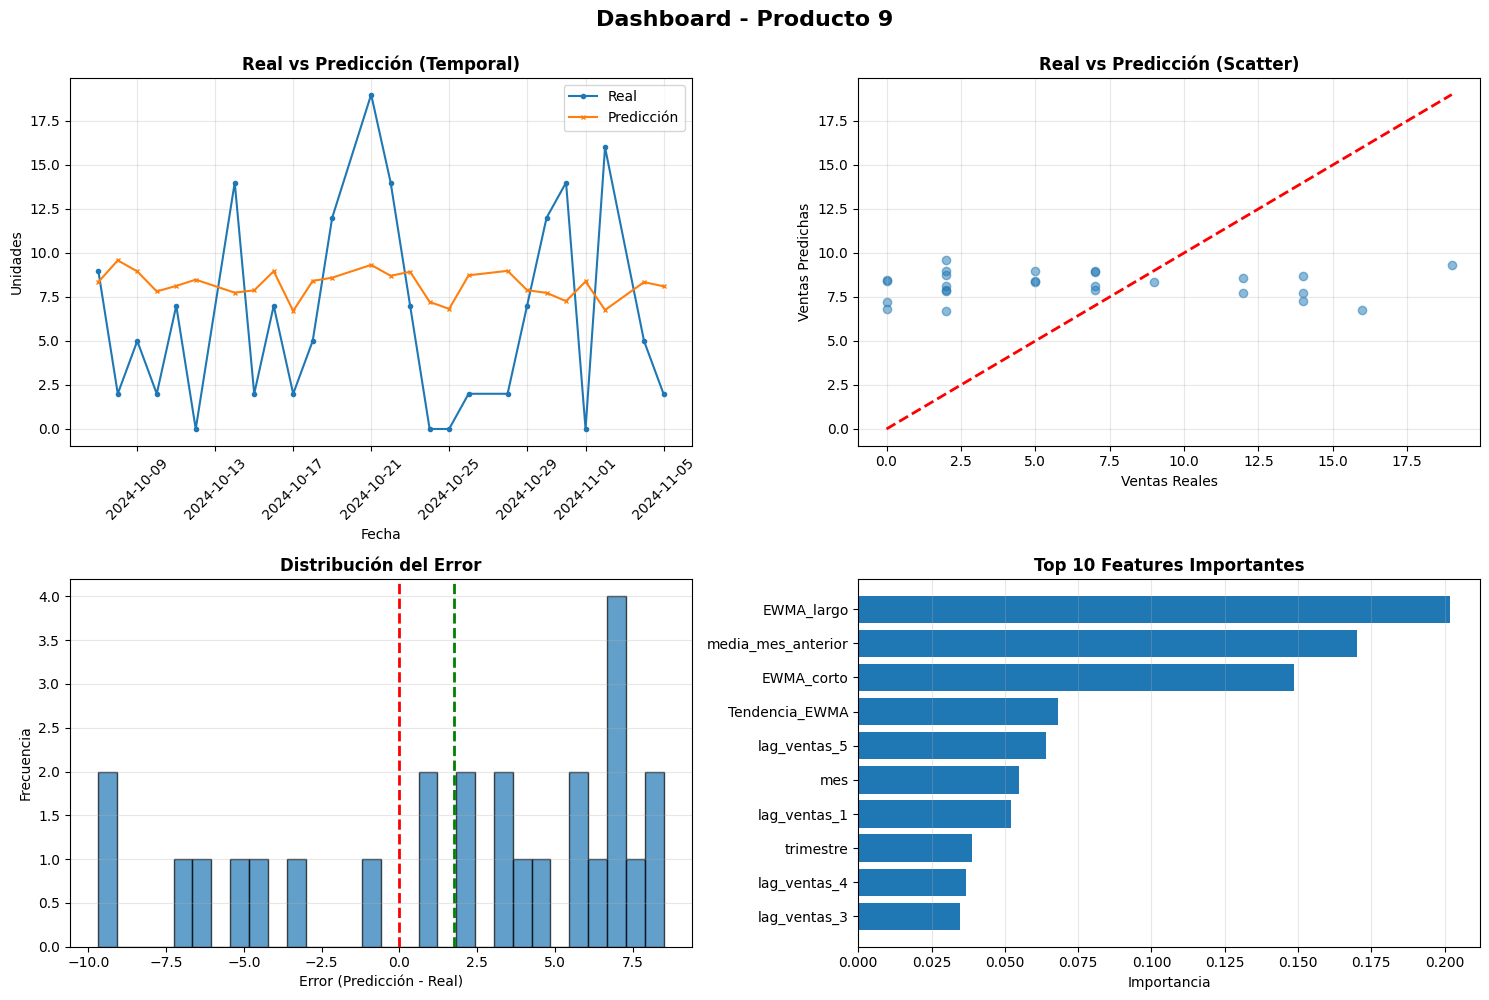


🔄 Entrenando modelo para Producto 78...
   ✓ MAE: 5.77 | RMSE: 7.16 | R²: -0.0002

   📍 Producto 78
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07        16    8.789091 -7.210909   7.210909
    2024-10-08        16    7.681824 -8.318176   8.318176
    2024-10-09        14    9.990187 -4.009813   4.009813

   📊 Estadísticas del error:
      Error medio:             -0.98
      Error abs medio:          5.77
      Error máximo:            21.78
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo   MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 78 5.771 51.3012 7.1625 -0.0002     67.81      64.81 0.7126    51.04

🏆 Mejor modelo: RF Producto 78 (RMSE: 7.1625)


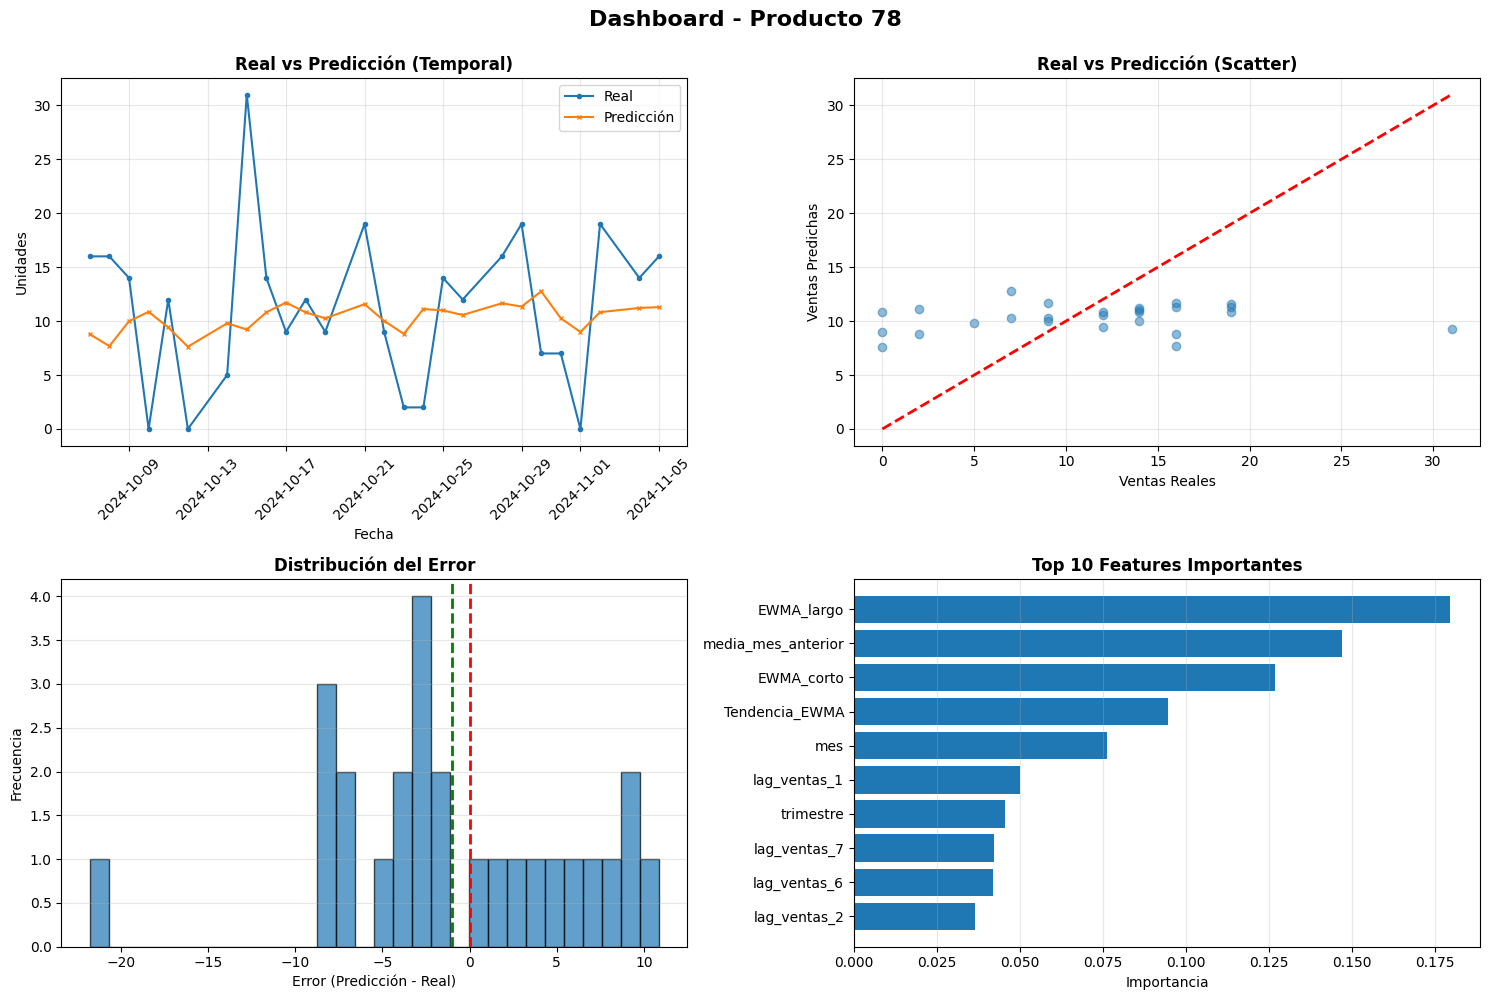


🔄 Entrenando modelo para Producto 7...
   ✓ MAE: 3.48 | RMSE: 3.83 | R²: -0.9072

   📍 Producto 7
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         0    5.263153 5.263153   5.263153
    2024-10-08         0    5.820001 5.820001   5.820001
    2024-10-09         0    5.487810 5.487810   5.487810

   📊 Estadísticas del error:
      Error medio:              2.59
      Error abs medio:          3.48
      Error máximo:             6.06
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 7 3.4831 14.7042 3.8346 -0.9072     96.64     114.16 0.9344   137.21

🏆 Mejor modelo: RF Producto 7 (RMSE: 3.8346)


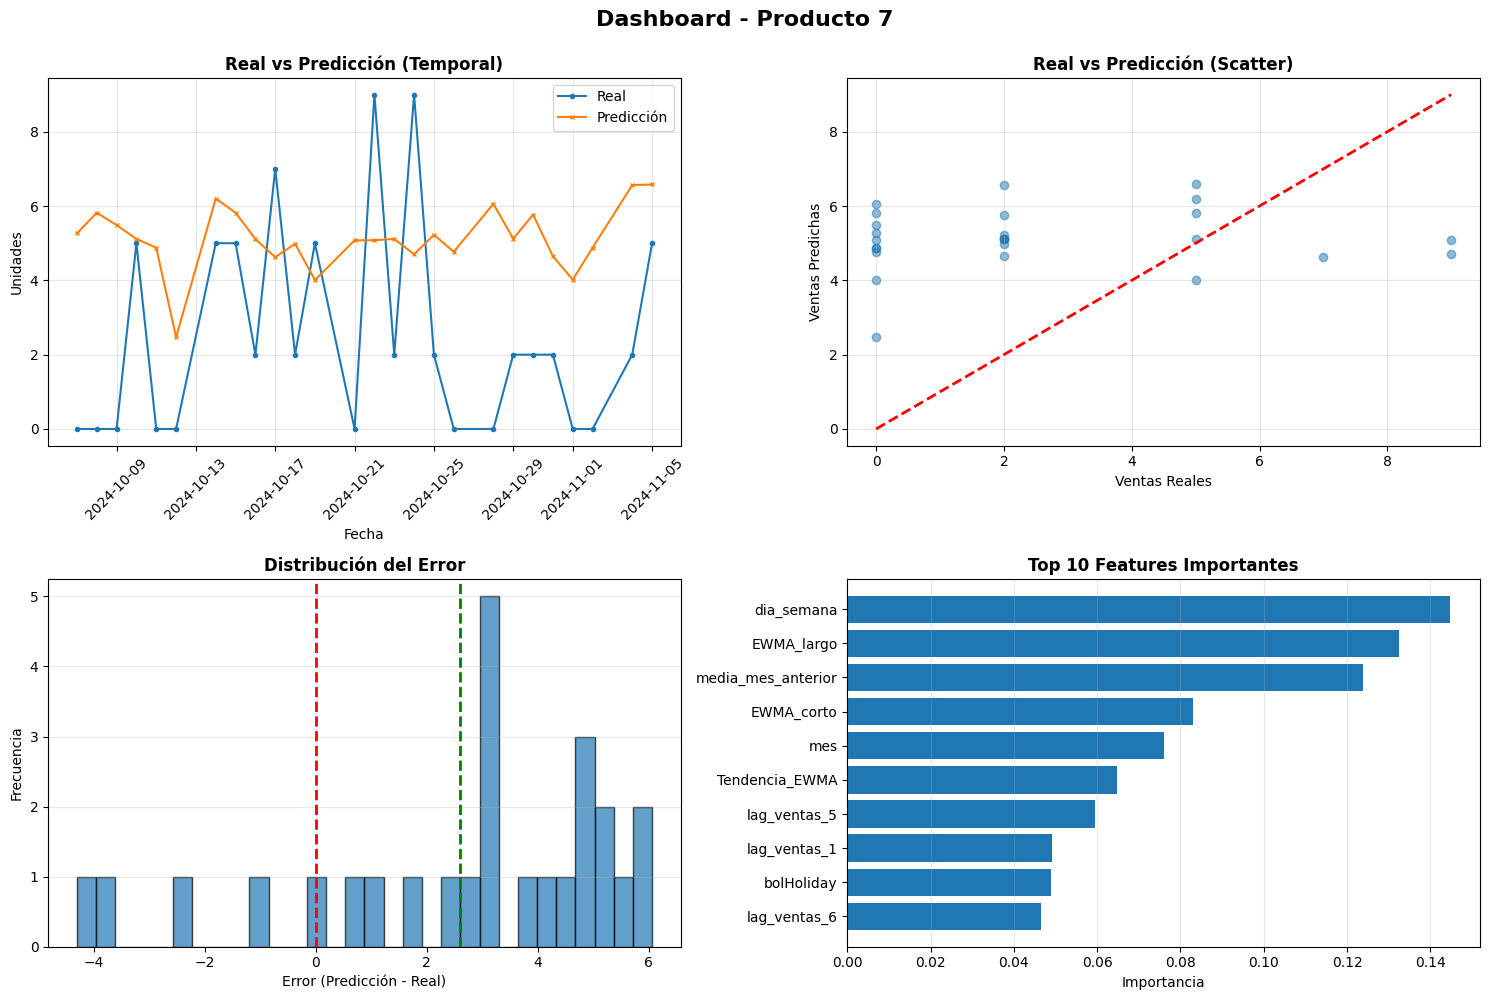


🔄 Entrenando modelo para Producto 13...
   ✓ MAE: 3.30 | RMSE: 3.81 | R²: -0.2509

   📍 Producto 13
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion    error  error_abs
    2024-10-07         2    6.365675 4.365675   4.365675
    2024-10-08         2    6.526509 4.526509   4.526509
    2024-10-09         2    6.229458 4.229458   4.229458

   📊 Estadísticas del error:
      Error medio:              1.63
      Error abs medio:          3.30
      Error máximo:             7.50
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 13 3.2975 14.4796 3.8052 -0.2509     102.8      83.78 0.7275    83.24

🏆 Mejor modelo: RF Producto 13 (RMSE: 3.8052)


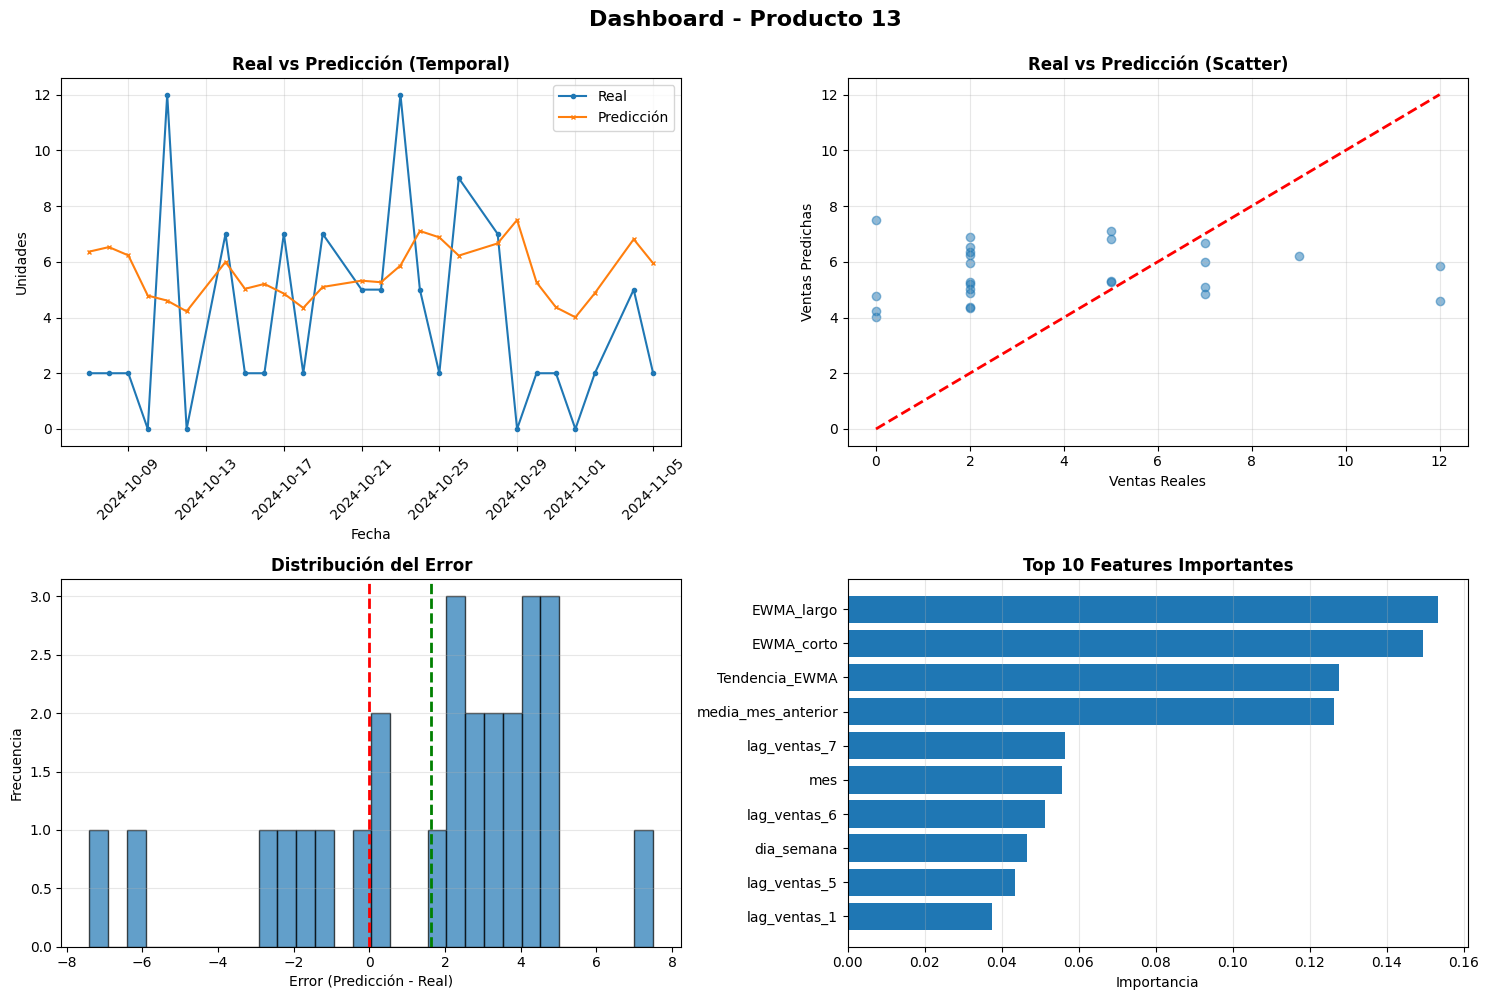


🔄 Entrenando modelo para Producto 15...
   ✓ MAE: 3.23 | RMSE: 4.03 | R²: -0.0160

   📍 Producto 15
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    6.193598 -0.806402   0.806402
    2024-10-08         5    5.451239  0.451239   0.451239
    2024-10-09         9    5.794329 -3.205671   3.205671

   📊 Estadísticas del error:
      Error medio:             -0.07
      Error abs medio:          3.23
      Error máximo:             8.14
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
      RF Producto 15 3.2287 16.2383 4.0297 -0.016     56.93       68.8 0.7721    56.72

🏆 Mejor modelo: RF Producto 15 (RMSE: 4.0297)


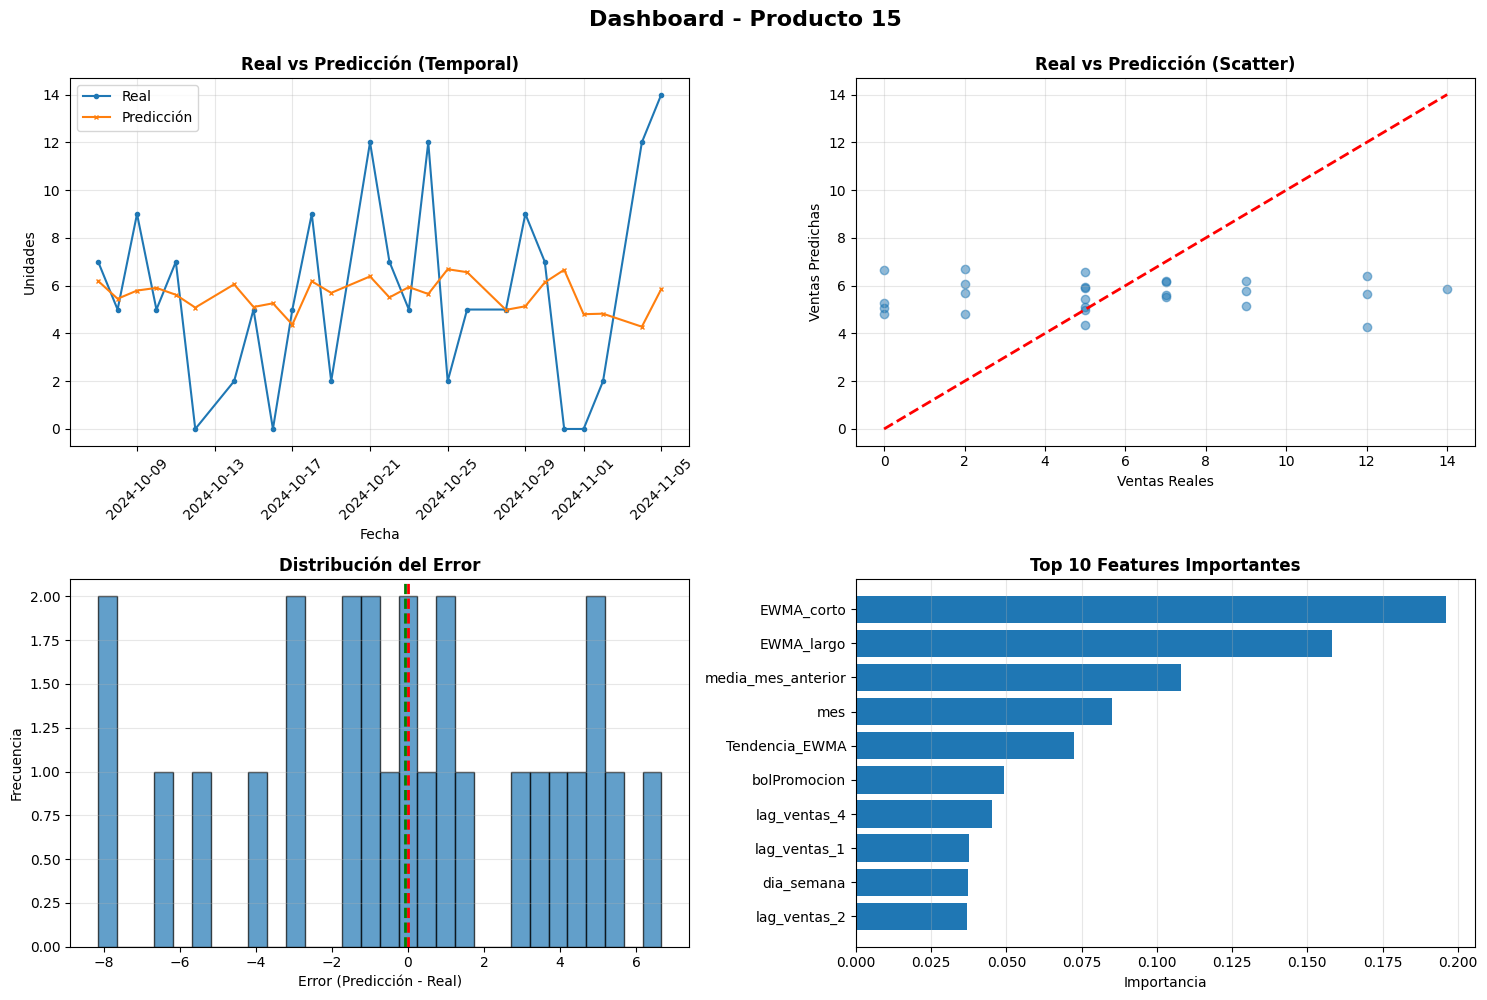


🔄 Entrenando modelo para Producto 391...
   ✓ MAE: 3.13 | RMSE: 3.83 | R²: -0.0348

   📍 Producto 391
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         5    4.940210 -0.059790   0.059790
    2024-10-08         9    5.522462 -3.477538   3.477538
    2024-10-09         0    5.111370  5.111370   5.111370

   📊 Estadísticas del error:
      Error medio:              1.13
      Error abs medio:          3.13
      Error máximo:            10.82
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
     RF Producto 391 3.1319 14.6525 3.8279 -0.0348     66.37     101.95 0.6814    92.53

🏆 Mejor modelo: RF Producto 391 (RMSE: 3.8279)


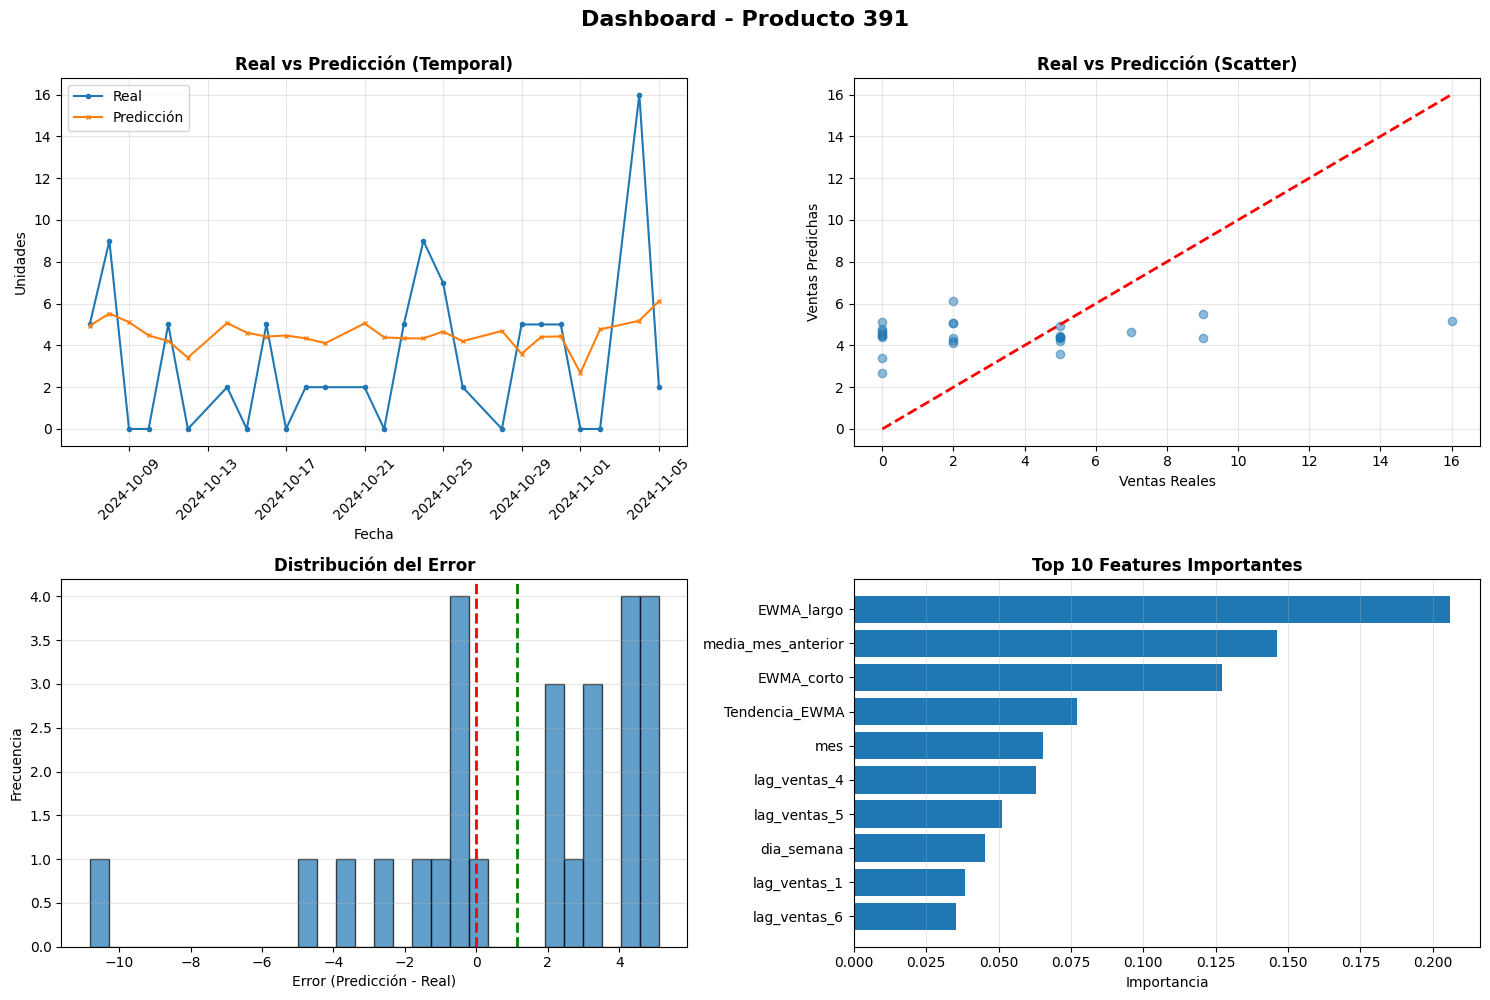


🔄 Entrenando modelo para Producto 3...
   ✓ MAE: 4.26 | RMSE: 5.44 | R²: 0.0249

   📍 Producto 3
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         7    5.150927 -1.849073   1.849073
    2024-10-08         5    5.058890  0.058890   0.058890
    2024-10-09         5    4.952626 -0.047374   0.047374

   📊 Estadísticas del error:
      Error medio:             -0.27
      Error abs medio:          4.26
      Error máximo:            13.45
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
       RF Producto 3 4.2635 29.5661 5.4375 0.0249     68.36      80.81 0.9217    66.38

🏆 Mejor modelo: RF Producto 3 (RMSE: 5.4375)


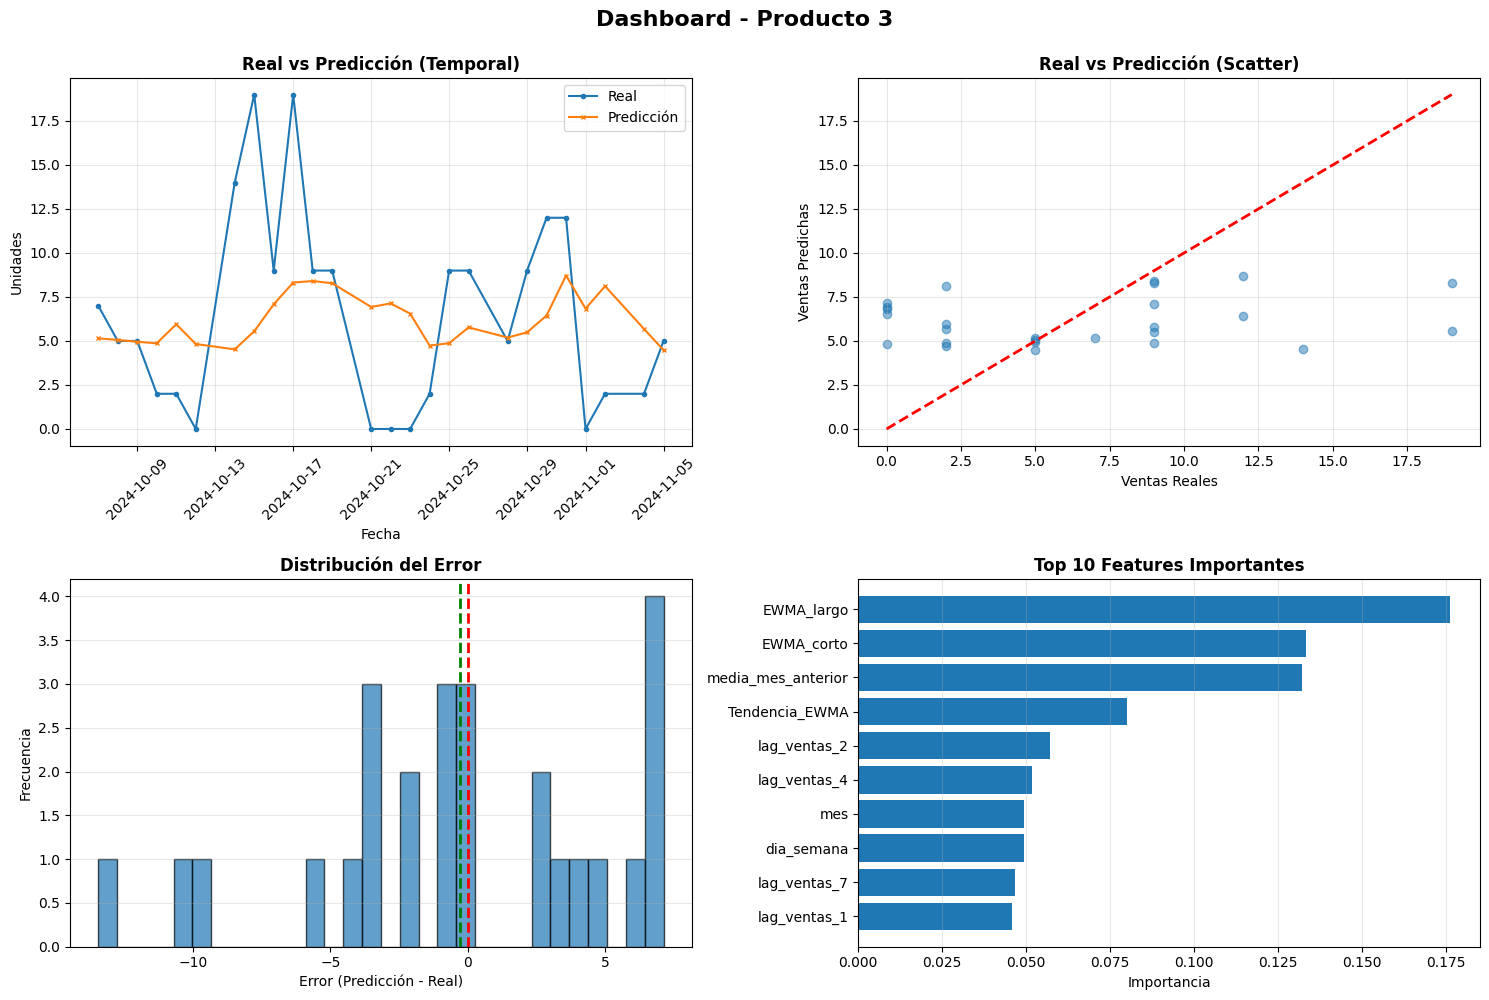


🔄 Entrenando modelo para Producto 131...
   ✓ MAE: 3.17 | RMSE: 3.76 | R²: 0.0521

   📍 Producto 131
      Train: 583 | Test: 26

   📋 Primeras 3 predicciones:
   idSecuencia  udsVenta  prediccion     error  error_abs
    2024-10-07         9    6.155128 -2.844872   2.844872
    2024-10-08         9    6.347186 -2.652814   2.652814
    2024-10-09         2    7.128284  5.128284   5.128284

   📊 Estadísticas del error:
      Error medio:              0.80
      Error abs medio:          3.17
      Error máximo:             7.91
      Error % medio:             inf%

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE     MSE   RMSE     R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
     RF Producto 131 3.1742 14.1138 3.7568 0.0521     58.36      95.34 0.7414    85.08

🏆 Mejor modelo: RF Producto 131 (RMSE: 3.7568)


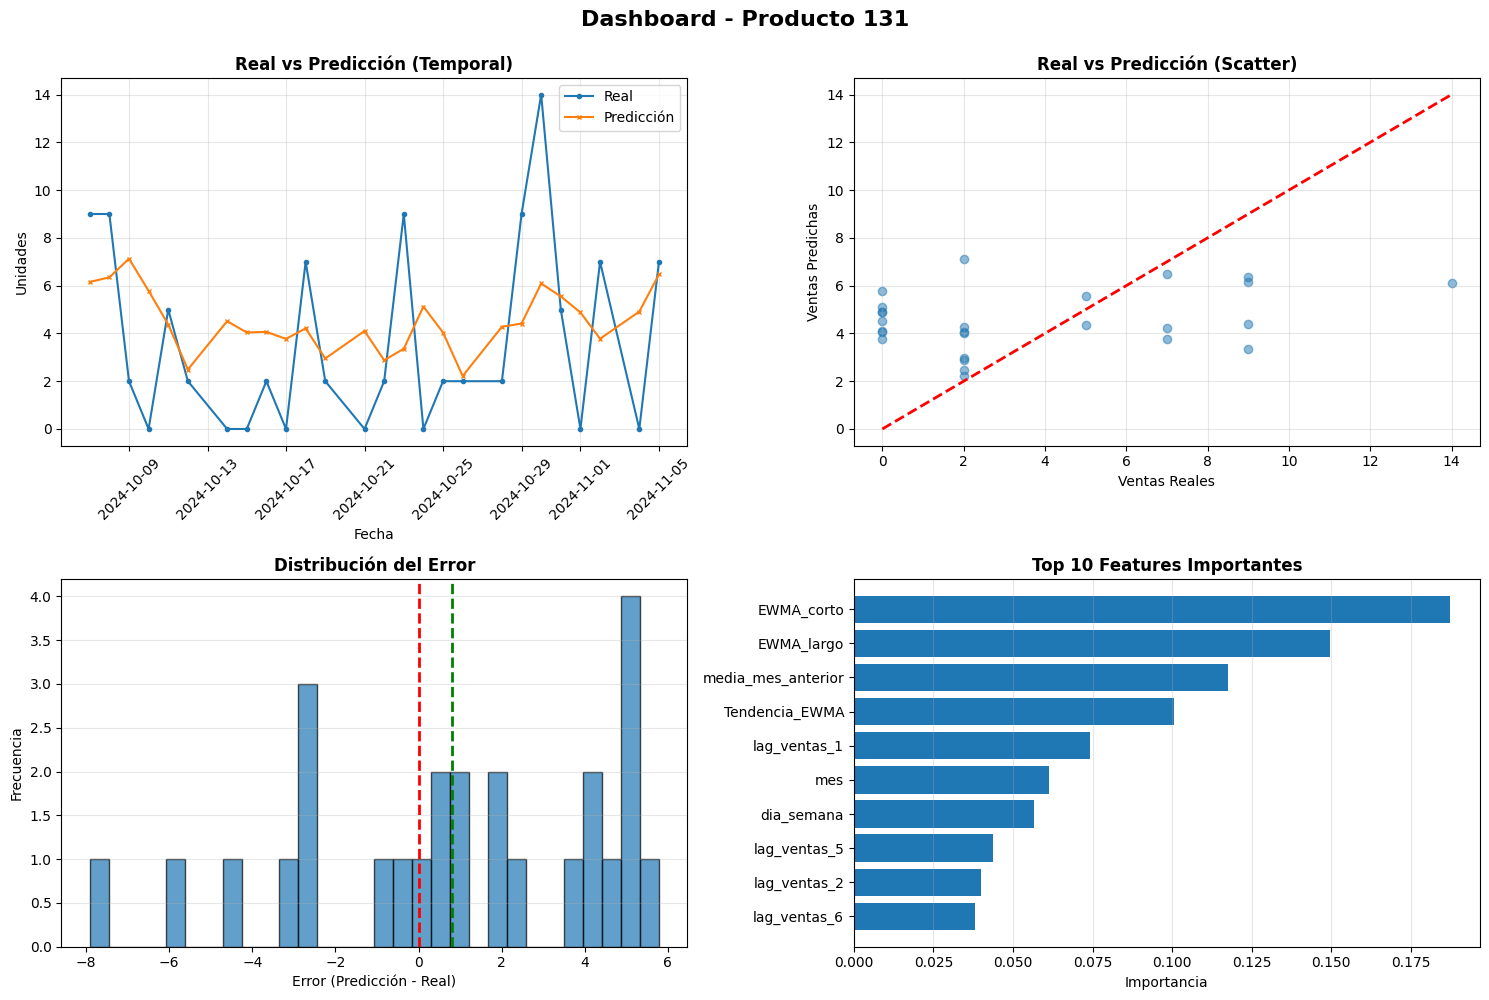

In [11]:

# ============================================================================
# 3. MODELOS POR PRODUCTO (TOP 10)
# ============================================================================

print("\n" + "="*100)
print("📍 MODELO 3: RANDOM FOREST POR PRODUCTO (TOP 10)")
print("="*100)

top_productos = df_train.groupby('producto')['udsVenta'].sum().nlargest(10).index.tolist()
print(f"\n🏆 Top 10 productos: {top_productos}")

modelos_producto = {}

for producto in top_productos:
    print(f"\n🔄 Entrenando modelo para Producto {producto}...")
    
    # Filtrar datos
    train_prod = df_train[df_train['producto'] == producto]
    test_prod = df_test[df_test['producto'] == producto].dropna()
    
    if len(test_prod) == 0:
        print(f"   ⚠️  No hay datos de validación")
        continue
    
    if len(train_prod) < 100:
        print(f"   ⚠️  Datos insuficientes ({len(train_prod)} registros)")
        continue
    
    X_train_p = train_prod[FEATURES]
    y_train_p = train_prod[TARGET]
    X_test_p = test_prod[FEATURES]
    y_test_p = test_prod[TARGET]
    
    # Entrenar
    rf_producto = RandomForestRegressor(
        **study_rf.best_params,
        random_state=42,
        n_jobs=-1
        )
    
    rf_producto.fit(X_train_p, y_train_p)
    y_pred_p = rf_producto.predict(X_test_p)
    
    modelos_producto[producto] = rf_producto
    
    # Calcular métricas y GUARDAR
    metricas_producto = calcular_metricas(y_test_p, y_pred_p, f"RF Producto {producto}")
    todas_metricas.append(metricas_producto)
    
    print(f"   ✓ MAE: {metricas_producto['MAE']:.2f} | RMSE: {metricas_producto['RMSE']:.2f} | R²: {metricas_producto['R2']:.4f}")
    
    # Preparar datos
    test_prod_pred = test_prod.copy()
    test_prod_pred['prediccion'] = y_pred_p
    test_prod_pred['error'] = y_pred_p - test_prod_pred[TARGET]
    test_prod_pred['error_abs'] = np.abs(test_prod_pred['error'])
    test_prod_pred['error_pct'] = (test_prod_pred['error_abs'] / test_prod_pred[TARGET]) * 100
    test_prod_pred = test_prod_pred.sort_values('idSecuencia')
    
    print(f"\n   📍 Producto {producto}")
    print(f"      Train: {len(train_prod)} | Test: {len(test_prod_pred)}")
    
    # Primeras predicciones
    print(f"\n   📋 Primeras 3 predicciones:")
    cols = ['idSecuencia', TARGET, 'prediccion', 'error', 'error_abs']
    print("   " + test_prod_pred[cols].head(3).to_string(index=False).replace('\n', '\n   '))
    
    # Estadísticas
    print(f"\n   📊 Estadísticas del error:")
    print(f"      Error medio:          {test_prod_pred['error'].mean():>8.2f}")
    print(f"      Error abs medio:      {test_prod_pred['error_abs'].mean():>8.2f}")
    print(f"      Error máximo:         {test_prod_pred['error_abs'].max():>8.2f}")
    print(f"      Error % medio:        {test_prod_pred['error_pct'].mean():>8.2f}%")
    
    if len(test_prod_pred) >= 2:
        resumen_metricas([metricas_producto])
        
        try:
            dashboard_prediccion(
                df=test_prod_pred,
                col_fecha='idSecuencia',
                col_real=TARGET,
                col_pred='prediccion',
                modelo=rf_producto,
                feature_names=FEATURES,
                titulo_principal=f'Dashboard - Producto {producto}',
                figsize=(15, 10)
            )
        except Exception as e:
            print(f"   ⚠️  Error en dashboard: {str(e)}")


# Resumen final


🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS

📊 Resumen de todas las métricas:

📊 RESUMEN DE MÉTRICAS
           Algoritmo    MAE      MSE    RMSE      R2  MAPE (%)  SMAPE (%)  RMSSE  MAE (%)
        RF Cluster 3 1.0876   2.7614  1.6618  0.0747     53.89     168.28 0.7457   133.92
      RF Global Test 1.5822   5.6468  2.3763  0.2631     48.88     143.94 0.7282    96.90
        RF Cluster 0 1.8098   6.5437  2.5581  0.1110     39.40     125.30 0.7354    93.73
        RF Cluster 1 2.8035  12.9602  3.6000  0.1380     55.90      98.42 0.7195    73.52
     RF Producto 131 3.1742  14.1138  3.7568  0.0521     58.36      95.34 0.7414    85.08
      RF Producto 13 3.2975  14.4796  3.8052 -0.2509    102.80      83.78 0.7275    83.24
     RF Producto 391 3.1319  14.6525  3.8279 -0.0348     66.37     101.95 0.6814    92.53
       RF Producto 7 3.4831  14.7042  3.8346 -0.9072     96.64     114.16 0.9344   137.21
      RF Producto 15 3.2287  16.2383  4.0297 -0.0160     56.93      68.80 0.7721 

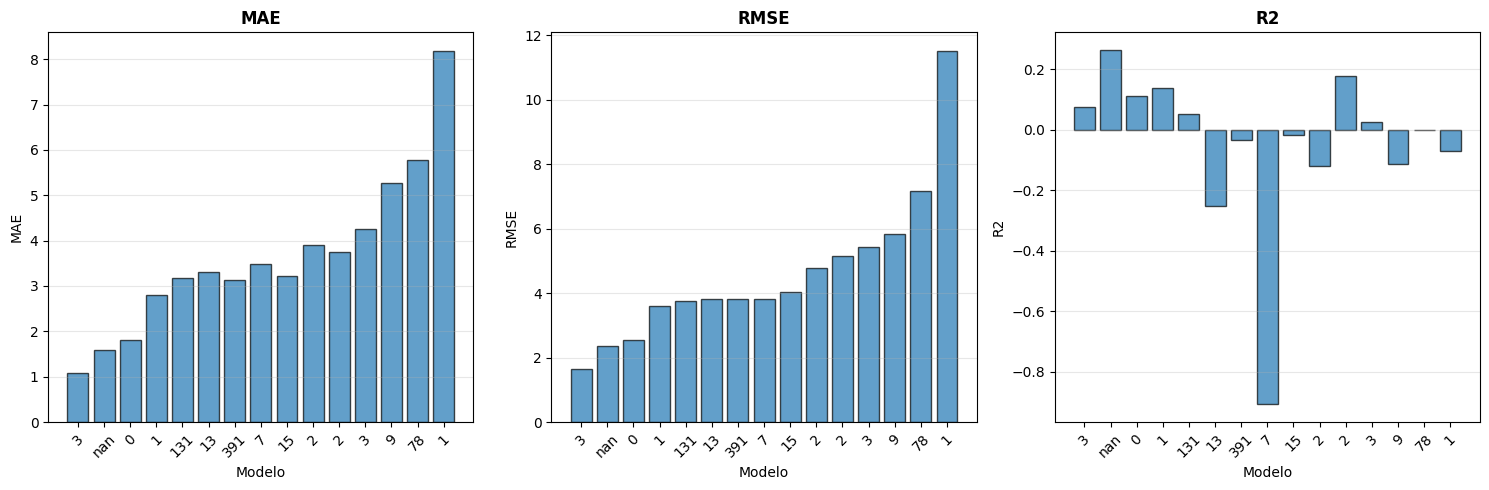


📊 ANÁLISIS POR CATEGORÍAS DE MODELOS

🌍 MODELOS GLOBALES:
     Algoritmo    MAE   RMSE     R2
RF Global Test 1.5822 2.3763 0.2631

   Promedio RMSE: 2.38

🎯 MODELOS POR CLUSTER:
   Algoritmo    MAE   RMSE     R2
RF Cluster 3 1.0876 1.6618 0.0747
RF Cluster 0 1.8098 2.5581 0.1110
RF Cluster 1 2.8035 3.6000 0.1380
RF Cluster 2 3.7512 5.1550 0.1788

   Promedio RMSE: 3.24
   Mejor cluster: RF Cluster 3 (RMSE: 1.66)
   Peor cluster: RF Cluster 2 (RMSE: 5.16)

🛒 MODELOS POR PRODUCTO:
      Algoritmo    MAE    RMSE      R2
RF Producto 131 3.1742  3.7568  0.0521
 RF Producto 13 3.2975  3.8052 -0.2509
RF Producto 391 3.1319  3.8279 -0.0348
  RF Producto 7 3.4831  3.8346 -0.9072
 RF Producto 15 3.2287  4.0297 -0.0160
  RF Producto 2 3.9017  4.7872 -0.1210
  RF Producto 3 4.2635  5.4375  0.0249
  RF Producto 9 5.2637  5.8512 -0.1122
 RF Producto 78 5.7710  7.1625 -0.0002
  RF Producto 1 8.1817 11.5208 -0.0697

   Promedio RMSE: 5.40
   Mejor producto: RF Producto 131 (RMSE: 3.76)
   Peor produc

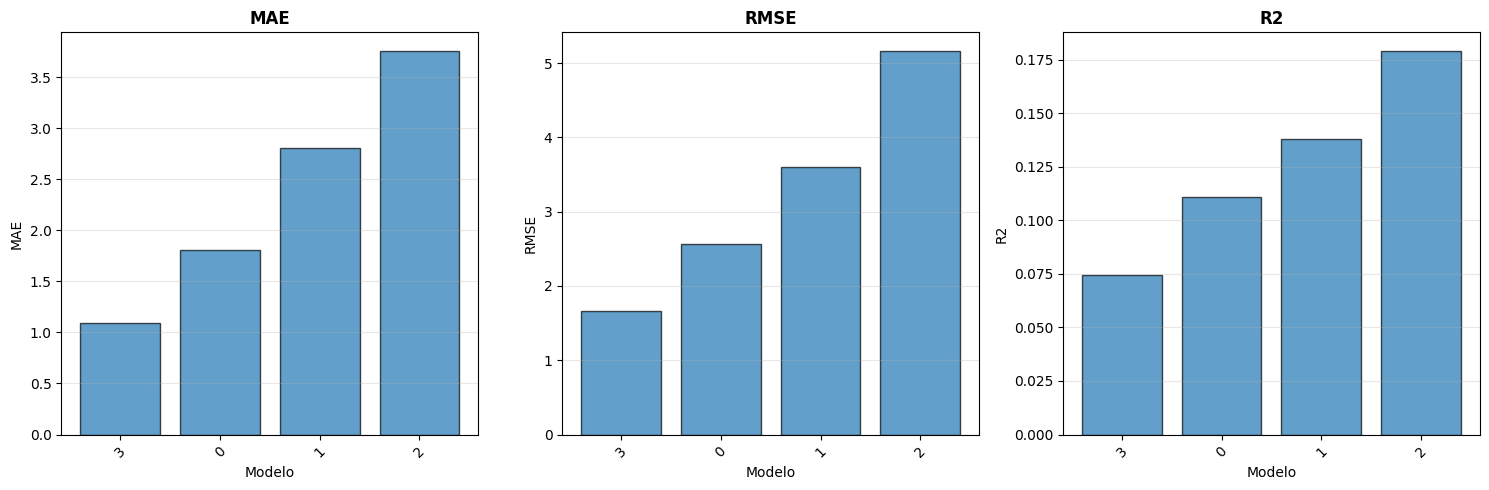


📊 Comparación entre productos:


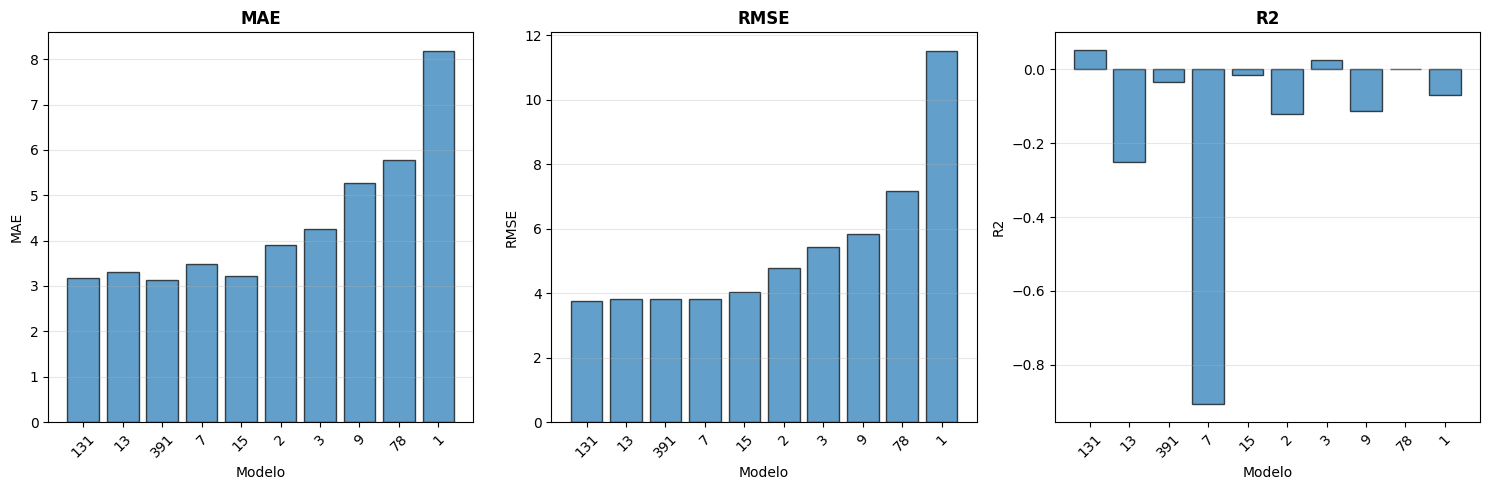


✅ ANÁLISIS COMPLETO FINALIZADO

📊 Total de modelos evaluados: 15
   - Modelos globales: 1
   - Modelos por cluster: 4
   - Modelos por producto: 10


In [12]:

# ============================================================================
# 4. RESUMEN FINAL DE TODOS LOS MODELOS
# ============================================================================

print("\n" + "="*100)
print("🏆 RESUMEN FINAL - COMPARACIÓN DE TODOS LOS MODELOS")
print("="*100)

if todas_metricas:
    # Mostrar tabla completa de métricas
    print("\n📊 Resumen de todas las métricas:")
    resumen_metricas(todas_metricas)
    
    # Comparar métricas
    df_comparacion_final = comparar_metricas(todas_metricas, ordenar_por='RMSE')
    
    print("\n" + "="*100)
    print("📈 RANKING DE MODELOS POR RMSE")
    print("="*100)
    print(df_comparacion_final[['Algoritmo', 'MAE', 'RMSE', 'R2', 'MAPE (%)']].to_string(index=False))
    
    # Gráfico comparativo de TODOS los modelos
    print("\n📊 Generando gráficos comparativos...")
    grafico_comparacion_metricas(df_comparacion_final, metricas=['MAE', 'RMSE', 'R2'])
    
    # Análisis por categorías
    print("\n" + "="*100)
    print("📊 ANÁLISIS POR CATEGORÍAS DE MODELOS")
    print("="*100)
    
    # Separar por tipo de modelo
    df_global = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Global')]
    df_clusters = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Cluster')]
    df_productos = df_comparacion_final[df_comparacion_final['Algoritmo'].str.contains('Producto')]
    
    print("\n🌍 MODELOS GLOBALES:")
    if len(df_global) > 0:
        print(df_global[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_global['RMSE'].mean():.2f}")
    
    print("\n🎯 MODELOS POR CLUSTER:")
    if len(df_clusters) > 0:
        print(df_clusters[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_clusters['RMSE'].mean():.2f}")
        print(f"   Mejor cluster: {df_clusters.iloc[0]['Algoritmo']} (RMSE: {df_clusters.iloc[0]['RMSE']:.2f})")
        print(f"   Peor cluster: {df_clusters.iloc[-1]['Algoritmo']} (RMSE: {df_clusters.iloc[-1]['RMSE']:.2f})")
    
    print("\n🛒 MODELOS POR PRODUCTO:")
    if len(df_productos) > 0:
        print(df_productos[['Algoritmo', 'MAE', 'RMSE', 'R2']].to_string(index=False))
        print(f"\n   Promedio RMSE: {df_productos['RMSE'].mean():.2f}")
        print(f"   Mejor producto: {df_productos.iloc[0]['Algoritmo']} (RMSE: {df_productos.iloc[0]['RMSE']:.2f})")
        print(f"   Peor producto: {df_productos.iloc[-1]['Algoritmo']} (RMSE: {df_productos.iloc[-1]['RMSE']:.2f})")
    
    # Mejor modelo general
    print("\n" + "="*100)
    print("🥇 MEJOR MODELO GENERAL")
    print("="*100)
    mejor_idx = df_comparacion_final['RMSE'].idxmin()
    mejor_modelo = df_comparacion_final.loc[mejor_idx]
    
    print(f"\n🏆 {mejor_modelo['Algoritmo']}")
    print(f"   MAE:        {mejor_modelo['MAE']:.2f}")
    print(f"   RMSE:       {mejor_modelo['RMSE']:.2f}")
    print(f"   R²:         {mejor_modelo['R2']:.4f}")
    print(f"   MAPE:       {mejor_modelo['MAPE (%)']:.2f}%")
    print(f"   SMAPE:      {mejor_modelo['SMAPE (%)']:.2f}%")
    
    # Gráficos comparativos por categoría
    if len(df_clusters) > 1:
        print("\n📊 Comparación entre clusters:")
        grafico_comparacion_metricas(df_clusters, metricas=['MAE', 'RMSE', 'R2'])
    
    if len(df_productos) > 1:
        print("\n📊 Comparación entre productos:")
        grafico_comparacion_metricas(df_productos, metricas=['MAE', 'RMSE', 'R2'])
    
else:
    print("\n⚠️  No se generaron métricas para ningún modelo")

print("\n" + "="*100)
print("✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*100)
print(f"\n📊 Total de modelos evaluados: {len(todas_metricas)}")
print(f"   - Modelos globales: {len([m for m in todas_metricas if 'Global' in m['Algoritmo']])}")
print(f"   - Modelos por cluster: {len([m for m in todas_metricas if 'Cluster' in m['Algoritmo']])}")
print(f"   - Modelos por producto: {len([m for m in todas_metricas if 'Producto' in m['Algoritmo']])}")

# Salvar resultados

In [14]:
# salvar resultados en fichero
df_resultados = pd.DataFrame(todas_metricas)
df_resultados.to_csv('datos/resultados_metricas_rf.csv', index=False)